## 0.0 Imports

In [1]:
import pandas as pd
import inflection
import math
import numpy as np

import seaborn as sns

import pickle

import random

from boruta import BorutaPy
from scipy import stats as ss
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.core.display import Image

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso

0.1 Helper functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:100% !important; } </style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

    
def cramer_v(x, y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))


def cross_validation(x_training, kfold, model_name, model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed(range(1, kfold + 1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # define beggining and end of validation date:
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k * 6 * 7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k - 1) * 6 * 7)
        
        #filter the dataset:
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ]
        
        #training:
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']
        
        #validation
        xvalidation = validation.drop(['date','sales'], axis = 1)
        yvalidation = validation['sales']
        
        #model
        m = model.fit(xtraining, ytraining)
        
        #prediction
        yhat = m.predict(xvalidation)
        
        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        #store performance
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
    return pd.DataFrame( {'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str),


                         },index = [0])

jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Loading Data / files

df4 = pd.read_pickle('./03.pkl')
num_types = pd.read_pickle('./2 - num_types')
cat_types = pd.read_pickle('./2 - cat_types')

In [3]:
df1 = pd.read_csv('./rossmann-store-sales/store.csv', low_memory = False)
df2 = pd.read_csv('./rossmann-store-sales/train.csv', low_memory = False)

In [4]:
# merging both spreadsheets on Store.
df = pd.merge(df2, df1, how = 'left', on = 'Store')

# Data Description

## Renaming Columns

In [5]:
snakecase = lambda x: inflection.underscore(x)

cols = list(df.columns)
print(cols)
print()
cols = list(map(snakecase, cols))
print(cols)
print()
df.columns = cols
df.columns

['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo', 'state_holiday', 'school_holiday', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'promo_interval']



Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## Data Dimension

In [6]:
print(f'# of Rows: {df.shape[0]}')
print(f'# of Columns: {df.shape[1]}')

# of Rows: 1017209
# of Columns: 18


## Data Types

In [7]:
df.dtypes
df['date'] = pd.to_datetime(df.date)
df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Check NA

In [8]:
df.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Fillout NA

In [9]:
#competition_distance - hypothesis NA = very far away, assuming no competitor. 
print(df.competition_distance.max())
#set it to 200k on NAs
df.competition_distance = df['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
#df.isna().sum()

# comp open since month ... Theres a competitor at all? Or was it there before we open?
# assuming if no info, there is the distance that later on can serve as proxy for the 'influence' of a non-existent competitor
# so let´s fill this as the same date of store opening.
print(df.competition_open_since_month.unique())

# df['date'].dt.month
df.competition_open_since_month = df.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)
print(f'mo: {df.competition_open_since_month.unique()}')

# same approach for year:
print()
print( df.competition_open_since_year.unique() )
df.competition_open_since_year = df.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
print( df.competition_open_since_year.unique() )

#just using same approach for treating promo2s- HOWEVER to check on logic of that.
df.promo2_since_week = df.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)
df.promo2_since_year = df.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'] , axis = 1)

# mapping promo interval:
month_map = {1: 'Jan', 2:'Feb', 3: 'Mar', 4: 'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Ago', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
print(month_map)

print(f'month_interval {df.promo_interval.unique()}')
df['promo_interval'].fillna(0, inplace=True)
df['month_map'] = df['date'].dt.month.map(month_map)

df.promo_interval = df[['promo_interval','month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis =1)

75860.0
[ 9. 11. 12.  4. 10.  8. nan  3.  6.  5.  1.  2.  7.]
mo: [ 9. 11. 12.  4. 10.  8.  7.  3.  6.  5.  1.  2.]

[2008. 2007. 2006. 2009. 2015. 2013. 2014. 2000. 2011.   nan 2010. 2005.
 1999. 2003. 2012. 2004. 2002. 1961. 1995. 2001. 1990. 1994. 1900. 1998.]
[2008. 2007. 2006. 2009. 2015. 2013. 2014. 2000. 2011. 2010. 2005. 1999.
 2003. 2012. 2004. 2002. 1961. 1995. 2001. 1990. 1994. 1900. 1998.]
{1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Ago', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
month_interval [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']


In [10]:
df.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
dtype: int64

## Changing Data Types

In [11]:
df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                           int64
month_map                               object
dtype: object

In [12]:
df.competition_open_since_month = df['competition_open_since_month'].astype(int)
df.competition_open_since_year =  df['competition_open_since_year'].astype(int)
df.dtypes

df.promo2_since_week = df['promo2_since_week'].astype(int)
df.promo2_since_year = df['promo2_since_year'].astype(int)

## Descriptive Statistics

In [13]:
num_types = df.select_dtypes(include = ['int64','float64','int32'])
cat_types = df.select_dtypes(exclude = ['int64','float64','datetime64[ns]'])
print(df.dtypes)
num_types.to_pickle('./2 - num_types')
cat_types.to_pickle('./2 - cat_types')
#print(num_types)
# num_types.hist(bins = 25)

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                           int64
month_map                               object
dtype: object


### Numerical Attributes

In [14]:
# Central tendency  mean, median
ct1 = pd.DataFrame( num_types.apply(np.mean)).T
# print(ct1)
ct2 = pd.DataFrame( num_types.apply(np.median)).T
# print('---')
# print(ct2)


# Dispertion   std, min, max, range, skew, kurtosis

d1 = pd.DataFrame( num_types.apply(np.std)).T
d2 = pd.DataFrame( num_types.apply(min)).T
d3 = pd.DataFrame( num_types.apply(max)).T
d4 = pd.DataFrame( num_types.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_types.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame( num_types.apply(lambda x: x.kurtosis )).T

# concatenating:

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

print(m)

                      attributes     min       max     range         mean  median           std       skew                                           kurtosis
0                          store     1.0    1115.0    1114.0   558.429727   558.0    321.908493  -0.000955  <bound method NDFrame._add_numeric_operations....
1                    day_of_week     1.0       7.0       6.0     3.998341     4.0       1.99739   0.001593  <bound method NDFrame._add_numeric_operations....
2                          sales     0.0   41551.0   41551.0  5773.818972  5744.0   3849.924283    0.64146  <bound method NDFrame._add_numeric_operations....
3                      customers     0.0    7388.0    7388.0   633.145946   609.0    464.411506    1.59865  <bound method NDFrame._add_numeric_operations....
4                           open     0.0       1.0       1.0     0.830107     1.0      0.375539  -1.758045  <bound method NDFrame._add_numeric_operations....
5                          promo     0.0       1.0  

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

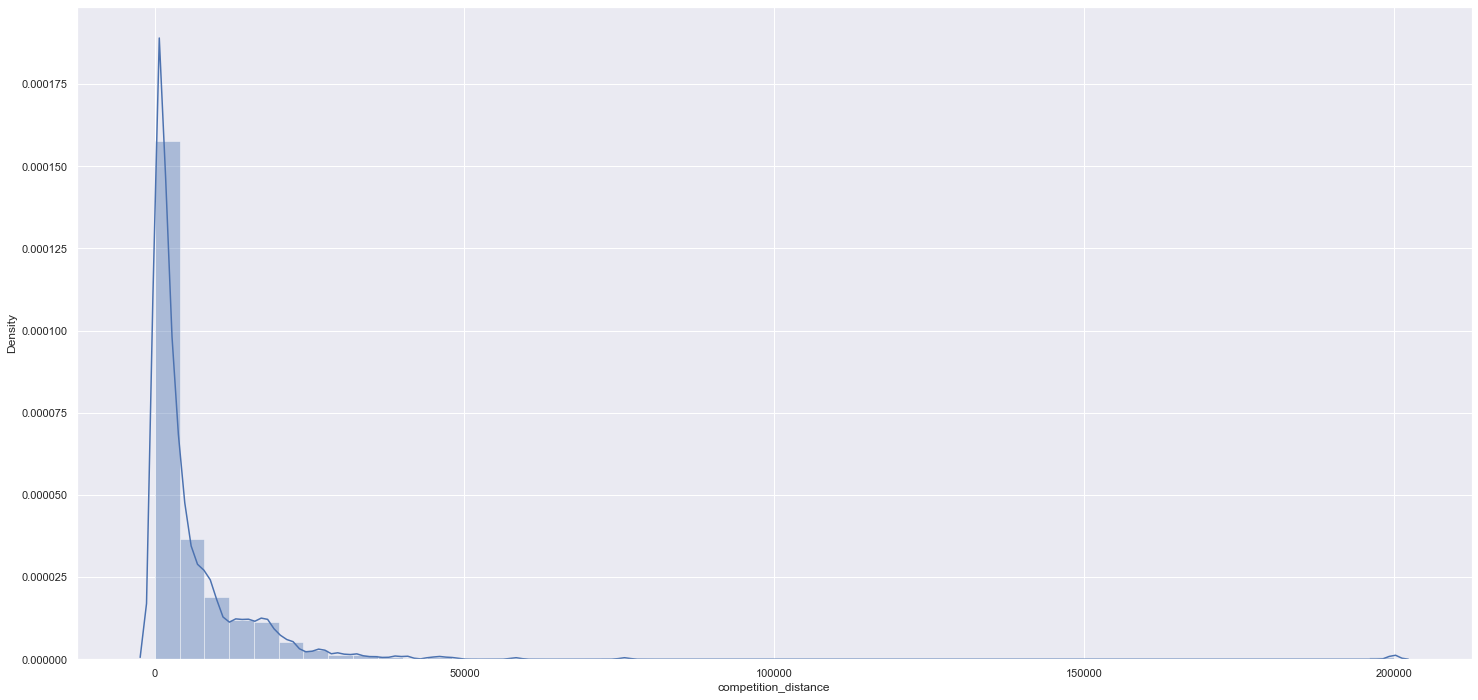

In [15]:
# sns.displot(df['competition_distance'])
sns.distplot(df['competition_distance']) #, kde = False)

### Categorical Attributes

In [16]:
# print(cat_types)
cat_types.apply( lambda x: x.unique().shape[0])

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
month_map                       12
dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

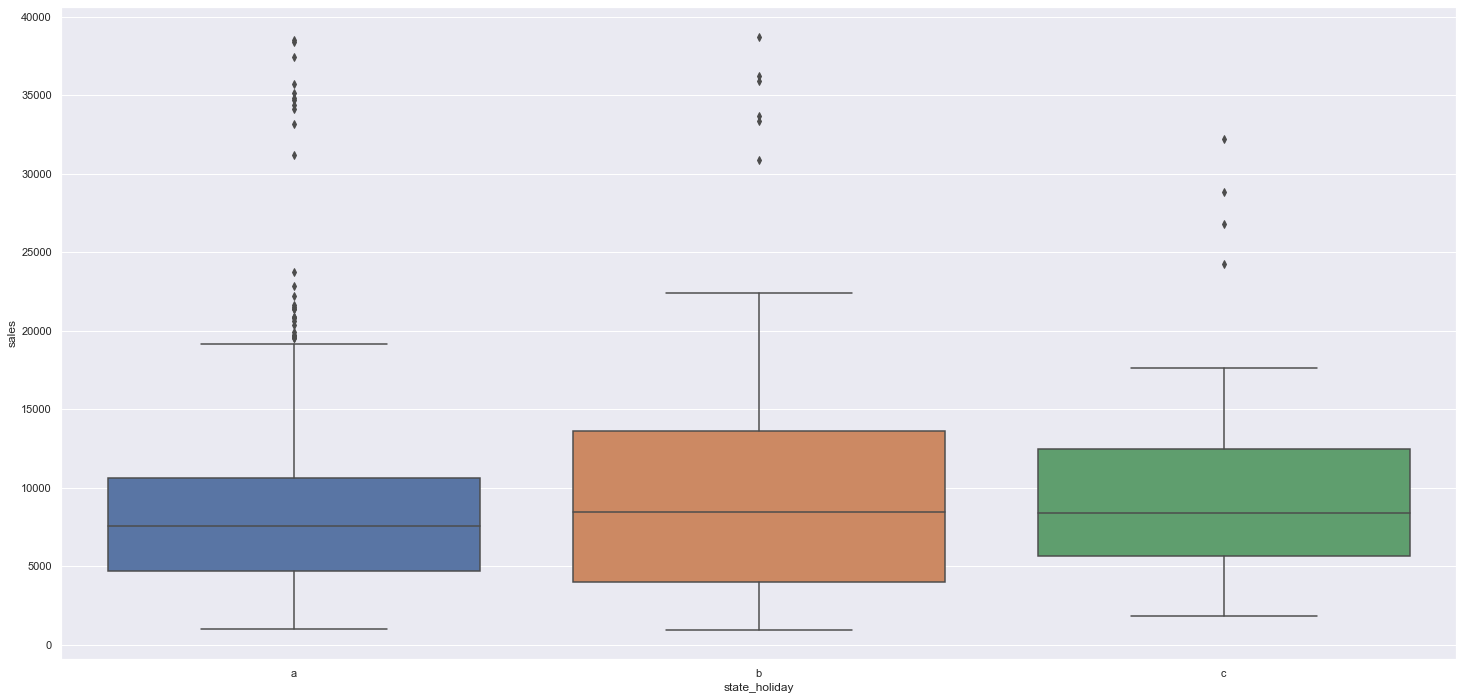

In [17]:
aux = df[(df['state_holiday'] != '0') & (df['sales'] > 0)]


sns.boxplot(x='state_holiday', y='sales', data=aux)

<AxesSubplot:xlabel='assortment', ylabel='sales'>

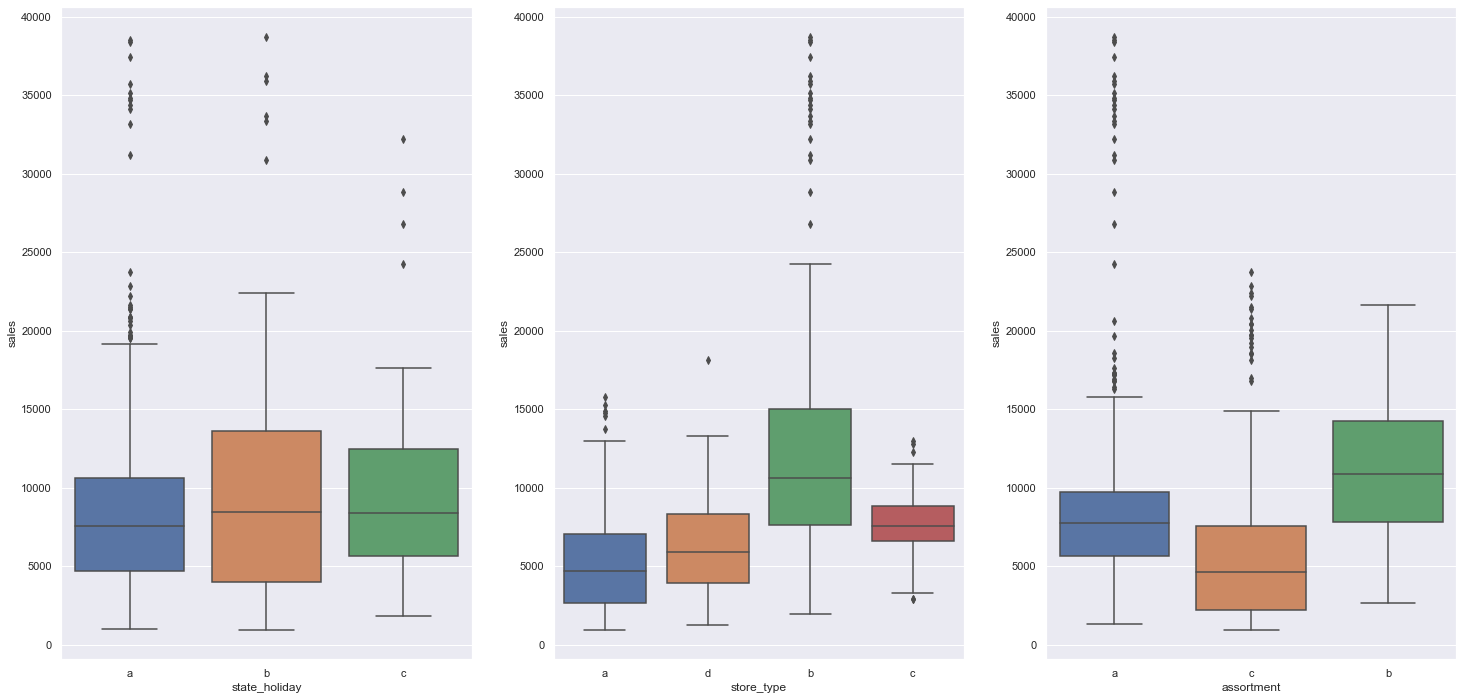

In [18]:
# Now using matplot to grid the boxplots:  (from matplotlib import pyplot as plt)
# plt.subplot( num linhas, num colunas, posicao atual)
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux)
plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux)
plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux)

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

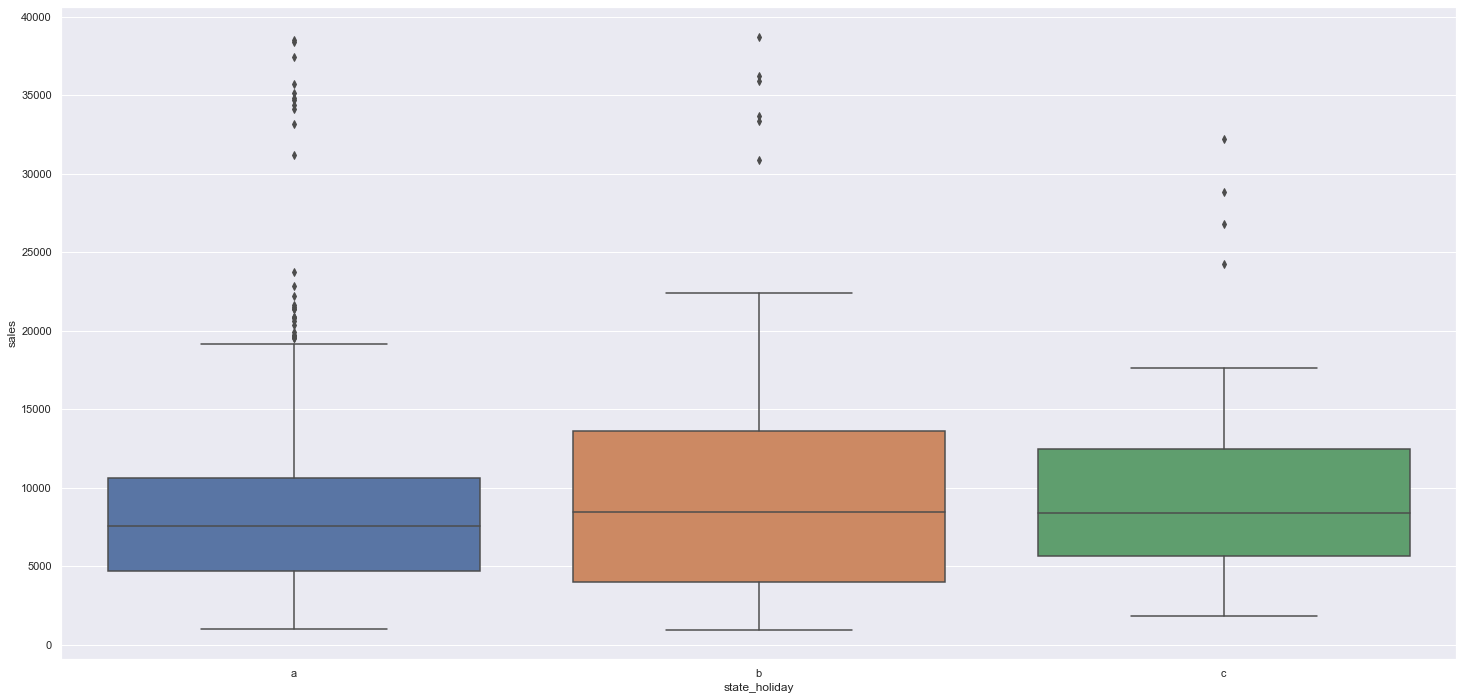

In [19]:
sns.boxplot(x='state_holiday', y='sales', data=aux)

In [20]:
df.to_pickle('./01.pkl')

# Feature Engineering

In [21]:
df2 = pd.read_pickle('./01.pkl')

In [22]:
df2.sample(20)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map
242856,1034,4,2014-12-25,0,0,0,0,c,1,a,a,13750.0,4,2015,0,52,2014,0,Dec
865382,928,5,2013-05-17,8551,818,1,1,0,0,d,c,1090.0,5,2013,1,31,2013,1,May
770904,110,5,2013-08-09,4482,686,1,0,0,0,a,c,46590.0,4,2013,0,32,2013,0,Ago
27614,855,2,2015-07-07,5237,614,1,0,0,0,a,a,3440.0,7,2015,1,45,2009,0,Jul
628563,489,7,2013-12-15,0,0,0,0,0,0,a,a,14960.0,11,2013,1,37,2009,0,Dec
590289,125,6,2014-01-18,8353,1178,1,0,0,0,a,a,760.0,12,2005,0,3,2014,0,Jan
249910,526,3,2014-12-17,18145,2049,1,1,0,0,a,a,120.0,12,2014,1,48,2011,1,Dec
624934,205,3,2013-12-18,8320,1027,1,1,0,0,a,a,110.0,12,2007,0,51,2013,0,Dec
89869,670,2,2015-05-12,6310,705,1,0,0,0,a,a,2060.0,5,2015,1,45,2009,1,May
992832,153,2,2013-01-22,8682,699,1,1,0,0,a,a,16240.0,10,2000,1,18,2011,0,Jan


## Mindmap Hypothesis Sales

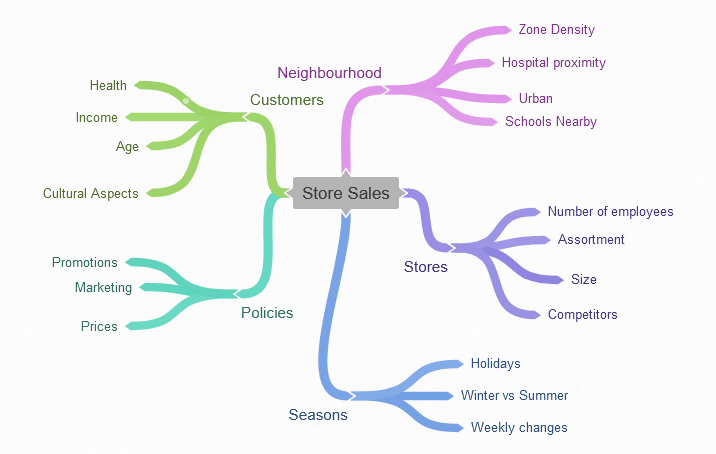

In [170]:
Image('./mindmap.png')

## Formulated Hypothesis

1 - Stores with more assortment items should sell more.

2 - Stores with more nearby competitors sell less.

3 - Stores with competitors from long date sell more.

4 - Stores with active promotions for more time sell more.

5 - Stores with less promotion days sell more.

6 - 

7 - Stores with more consecutive promotions sell more.

8 - Stores open on Chrimas sell more

9 - Stores shouls sell more the throughout the years.

10 - Stores should sell more at the 2nd semester.

11 - Stores sell more after the 10th on each month.

12 - Stores sell less on weekends.

13 - Stores sell less during school holidays.

## Feature Engineering

In [24]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                           int64
month_map                               object
dtype: object

In [25]:
# year column creation
df2.sample(4)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map
750641,1032,3,2013-08-28,10176,1030,1,1,0,1,d,c,270.0,2,2013,1,40,2012,0,Ago
971670,176,7,2013-02-10,0,0,0,0,0,0,a,a,3770.0,2,2013,0,6,2013,0,Feb
235069,920,5,2015-01-02,4656,414,1,0,0,1,a,a,850.0,2,2012,1,40,2014,1,Jan
421564,880,4,2014-06-19,0,0,0,1,a,1,a,c,4570.0,6,2014,0,25,2014,0,Jun


In [26]:
df2['year'] = df2['date'].dt.year
df2.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,year
866538,969,4,2013-05-16,3029,570,1,1,0,0,a,c,600.0,11,1999,1,10,2013,0,May,2013
691141,627,7,2013-10-20,0,0,0,0,0,1,c,c,3970.0,3,2010,0,42,2013,0,Oct,2013
141287,798,5,2015-03-27,6091,814,1,0,0,0,a,a,9560.0,4,2001,0,13,2015,0,Mar,2015
411577,928,6,2014-06-28,7990,641,1,0,0,0,d,c,1090.0,6,2014,1,31,2013,0,Jun,2014
316311,546,2,2014-10-07,16212,1776,1,1,0,0,a,a,580.0,1,2005,0,41,2014,0,Oct,2014


In [27]:
# month column
df2['month'] = df2['date'].dt.month
df2.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,year,month
102738,159,4,2015-04-30,10866,892,1,1,0,0,d,a,8530.0,3,2013,0,18,2015,0,Apr,2015,4
265337,1082,1,2014-12-01,12263,1474,1,1,0,0,c,a,440.0,4,2002,0,49,2014,0,Dec,2014,12
867039,355,3,2013-05-15,8702,1152,1,1,0,0,a,c,9720.0,8,2013,0,20,2013,0,May,2013,5
608094,90,4,2014-01-02,7486,1016,1,0,0,1,a,a,330.0,11,2007,0,1,2014,0,Jan,2014,1
210631,1012,6,2015-01-24,6733,608,1,0,0,0,d,c,6330.0,6,2004,1,39,2010,1,Jan,2015,1


In [28]:
df2['day'] = df2['date'].dt.day
df2.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,year,month,day
996652,628,6,2013-01-19,3475,473,1,0,0,0,a,c,2180.0,1,2013,0,3,2013,0,Jan,2013,1,19
940752,478,7,2013-03-10,0,0,0,0,0,0,d,c,1940.0,3,2012,0,10,2013,0,Mar,2013,3,10
549837,928,1,2014-02-24,4999,493,1,0,0,0,d,c,1090.0,2,2014,1,31,2013,1,Feb,2014,2,24
1013876,12,4,2013-01-03,4867,712,1,0,0,1,a,c,1070.0,1,2013,1,13,2010,1,Jan,2013,1,3
585647,1058,4,2014-01-23,6778,640,1,1,0,0,a,c,180.0,1,2014,1,35,2010,0,Jan,2014,1,23


In [29]:
# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
df2.sample(5)

C:\Users\fu\AppData\Local\Temp\ipykernel_3116\2768642984.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,year,month,day,week_of_year
533101,917,2,2014-03-11,5318,673,1,0,0,0,a,a,7240.0,2,2010,0,11,2014,0,Mar,2014,3,11,11
688236,1067,3,2013-10-23,5155,440,1,1,0,0,d,c,12020.0,7,2009,0,43,2013,0,Oct,2013,10,23,43
918244,270,6,2013-03-30,12071,1448,1,0,0,0,a,a,1450.0,7,2014,0,13,2013,0,Mar,2013,3,30,13
454560,426,2,2014-05-20,6329,737,1,1,0,0,a,a,250.0,5,2014,0,21,2014,0,May,2014,5,20,21
31642,423,5,2015-07-03,14447,2854,1,1,0,0,b,a,1270.0,5,2014,0,27,2015,0,Jul,2015,7,3,27


In [30]:
# year - week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')
df2.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,year,month,day,week_of_year,year_week
148861,567,5,2015-03-20,5812,704,1,1,0,0,c,a,1010.0,9,2012,1,18,2011,0,Mar,2015,3,20,12,2015-11
771300,506,5,2013-08-09,6501,762,1,0,0,1,a,a,1850.0,12,2014,1,18,2011,0,Ago,2013,8,9,32,2013-31
198139,785,3,2015-02-04,7648,632,1,1,0,0,d,c,970.0,7,2005,1,31,2013,1,Feb,2015,2,4,6,2015-05
374920,201,2,2014-08-05,5761,434,1,1,0,1,d,a,20260.0,8,2014,1,18,2014,0,Ago,2014,8,5,32,2014-31
1703,589,4,2015-07-30,6148,570,1,1,0,1,a,c,360.0,7,2015,1,18,2013,0,Jul,2015,7,30,31,2015-30


In [31]:
# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
df2.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,year,month,day,week_of_year,year_week,competition_since
239282,117,7,2014-12-28,0,0,0,0,0,0,a,a,3450.0,9,2011,0,52,2014,0,Dec,2014,12,28,52,2014-51,2011-09-01
941797,408,6,2013-03-09,4554,530,1,0,0,0,c,a,1560.0,3,2013,1,45,2009,0,Mar,2013,3,9,10,2013-09,2013-03-01
428283,909,5,2014-06-13,9618,911,1,0,0,1,a,c,1680.0,6,2014,1,45,2009,0,Jun,2014,6,13,24,2014-23,2014-06-01
306873,441,5,2014-10-17,5527,655,1,0,0,1,d,a,2530.0,10,2014,0,42,2014,0,Oct,2014,10,17,42,2014-41,2014-10-01
209731,112,6,2015-01-24,6172,744,1,0,0,0,a,a,1630.0,9,2009,0,4,2015,0,Jan,2015,1,24,4,2015-03,2009-09-01


In [32]:
# competition length time in months
df2['competition_length_months'] = ((df2['date'] - df2['competition_since'])/30) #.apply(lambda x: x.days )
df2.head(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,year,month,day,week_of_year,year_week,competition_since,competition_length_months
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,2015,7,31,31,2015-30,2008-09-01,84 days 03:12:00
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,1,Jul,2015,7,31,31,2015-30,2007-11-01,94 days 07:12:00
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,1,Jul,2015,7,31,31,2015-30,2006-12-01,105 days 11:12:00
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,2015,7,31,31,2015-30,2009-09-01,71 days 23:12:00
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,2015,7,31,31,2015-30,2015-04-01,4 days 00:48:00


In [33]:
df2['competition_length_months'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days ).astype(int)
df2.head(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,year,month,day,week_of_year,year_week,competition_since,competition_length_months
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,2015,7,31,31,2015-30,2008-09-01,84
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,1,Jul,2015,7,31,31,2015-30,2007-11-01,94
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,1,Jul,2015,7,31,31,2015-30,2006-12-01,105
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,2015,7,31,31,2015-30,2009-09-01,71
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,2015,7,31,31,2015-30,2015-04-01,4


In [34]:
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df['promo2_since_week'].astype(str)
df2.head(10)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,year,month,day,week_of_year,year_week,competition_since,competition_length_months,promo_since
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,2015,7,31,31,2015-30,2008-09-01,84,2015-31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,1,Jul,2015,7,31,31,2015-30,2007-11-01,94,2010-13
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,1,Jul,2015,7,31,31,2015-30,2006-12-01,105,2011-14
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,2015,7,31,31,2015-30,2009-09-01,71,2015-31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,2015,7,31,31,2015-30,2015-04-01,4,2015-31
5,6,5,2015-07-31,5651,589,1,1,0,1,a,a,310.0,12,2013,0,31,2015,0,Jul,2015,7,31,31,2015-30,2013-12-01,20,2015-31
6,7,5,2015-07-31,15344,1414,1,1,0,1,a,c,24000.0,4,2013,0,31,2015,0,Jul,2015,7,31,31,2015-30,2013-04-01,28,2015-31
7,8,5,2015-07-31,8492,833,1,1,0,1,a,a,7520.0,10,2014,0,31,2015,0,Jul,2015,7,31,31,2015-30,2014-10-01,10,2015-31
8,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,8,2000,0,31,2015,0,Jul,2015,7,31,31,2015-30,2000-08-01,182,2015-31
9,10,5,2015-07-31,7185,681,1,1,0,1,a,a,3160.0,9,2009,0,31,2015,0,Jul,2015,7,31,31,2015-30,2009-09-01,71,2015-31


In [35]:
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+ '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
df2.head(10)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,year,month,day,week_of_year,year_week,competition_since,competition_length_months,promo_since
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,1,Jul,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,1,Jul,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27
5,6,5,2015-07-31,5651,589,1,1,0,1,a,a,310.0,12,2013,0,31,2015,0,Jul,2015,7,31,31,2015-30,2013-12-01,20,2015-07-27
6,7,5,2015-07-31,15344,1414,1,1,0,1,a,c,24000.0,4,2013,0,31,2015,0,Jul,2015,7,31,31,2015-30,2013-04-01,28,2015-07-27
7,8,5,2015-07-31,8492,833,1,1,0,1,a,a,7520.0,10,2014,0,31,2015,0,Jul,2015,7,31,31,2015-30,2014-10-01,10,2015-07-27
8,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,8,2000,0,31,2015,0,Jul,2015,7,31,31,2015-30,2000-08-01,182,2015-07-27
9,10,5,2015-07-31,7185,681,1,1,0,1,a,a,3160.0,9,2009,0,31,2015,0,Jul,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27


In [36]:
# df2['promo_since'] = df2['promo_since_aux']

df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) /7).apply(lambda x: x.days).astype(int)

In [37]:
df2.head(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,year,month,day,week_of_year,year_week,competition_since,competition_length_months,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,1,Jul,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,1,Jul,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [38]:
# Store Assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' if x == 'c' else x)
df2.sample(12)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,year,month,day,week_of_year,year_week,competition_since,competition_length_months,promo_since,promo_time_week
934656,1072,6,2013-03-16,3874,385,1,0,0,0,a,extended,5380.0,8,2015,1,5,2010,0,Mar,2013,3,16,11,2013-10,2015-08-01,-29,2010-01-25,163
348236,714,3,2014-09-03,4751,324,1,1,0,1,d,extended,12070.0,10,2005,1,10,2013,0,Sept,2014,9,3,36,2014-35,2005-10-01,108,2013-03-04,78
556052,453,2,2014-02-18,5525,627,1,1,0,0,a,extended,75860.0,2,2014,0,8,2014,0,Feb,2014,2,18,8,2014-07,2014-02-01,0,2014-02-17,0
560525,466,5,2014-02-14,7186,786,1,0,0,0,a,extended,3110.0,3,2003,0,7,2014,0,Feb,2014,2,14,7,2014-06,2003-03-01,133,2014-02-10,0
769173,609,7,2013-08-11,0,0,0,0,0,0,a,basic,2070.0,9,2007,0,32,2013,0,Ago,2013,8,11,32,2013-31,2007-09-01,72,2013-08-05,0
398174,47,5,2014-07-11,6704,866,1,0,0,1,a,extended,270.0,4,2013,1,14,2013,1,Jul,2014,7,11,28,2014-27,2013-04-01,15,2013-04-01,66
542806,587,7,2014-03-02,0,0,0,0,0,0,d,extended,330.0,9,2006,1,14,2011,0,Mar,2014,3,2,9,2014-08,2006-09-01,91,2011-03-28,152
366680,398,4,2014-08-14,4608,526,1,0,0,1,c,extended,1540.0,8,2014,1,1,2012,0,Ago,2014,8,14,33,2014-32,2014-08-01,0,2011-12-26,137
59146,52,1,2015-06-08,5843,399,1,0,0,0,d,extended,450.0,4,2014,1,39,2010,0,Jun,2015,6,8,24,2015-23,2014-04-01,14,2010-09-20,246
722837,1103,7,2013-09-22,0,0,0,0,0,0,d,extended,1340.0,10,2006,1,5,2013,0,Sept,2013,9,22,38,2013-37,2006-10-01,84,2013-01-28,33


In [39]:
# state holiday
# a = public holiday, b = Easter holiday, c = Christmas, 0 = None

df2.state_holiday = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x =='b' else 'chritsmas' if x == 'c' else 'regular_day' if x == '0' else x)
df2.sample(12)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,year,month,day,week_of_year,year_week,competition_since,competition_length_months,promo_since,promo_time_week
208286,897,1,2015-01-26,3671,351,1,1,regular_day,0,c,extended,3290.0,1,2007,1,5,2013,0,Jan,2015,1,26,5,2015-04,2007-01-01,98,2013-01-28,104
1014066,202,4,2013-01-03,3868,365,1,0,regular_day,1,d,extended,5140.0,5,2010,0,1,2013,0,Jan,2013,1,3,1,2013-00,2010-05-01,32,2012-12-31,0
422779,980,3,2014-06-18,8379,629,1,1,regular_day,0,a,basic,4420.0,9,2005,0,25,2014,0,Jun,2014,6,18,25,2014-24,2005-09-01,107,2014-06-16,0
614211,632,6,2013-12-28,7543,966,1,0,regular_day,0,a,basic,3350.0,2,2010,0,52,2013,0,Dec,2013,12,28,52,2013-51,2010-02-01,47,2013-12-23,0
74854,150,1,2015-05-25,0,0,0,0,public_holiday,0,c,extended,31830.0,3,2010,0,22,2015,0,May,2015,5,25,22,2015-21,2010-03-01,63,2015-05-25,0
403966,269,6,2014-07-05,6724,895,1,0,regular_day,0,a,extended,60.0,6,2015,0,27,2014,0,Jul,2014,7,5,27,2014-26,2015-06-01,-12,2014-06-30,0
489325,626,6,2014-04-19,10829,996,1,0,regular_day,0,c,extended,10740.0,11,2013,0,16,2014,0,Apr,2014,4,19,16,2014-15,2013-11-01,5,2014-04-14,0
951496,72,4,2013-02-28,3301,412,1,0,regular_day,0,a,basic,2200.0,12,2009,1,13,2010,0,Feb,2013,2,28,9,2013-08,2009-12-01,39,2010-03-22,153
75883,64,7,2015-05-24,0,0,0,0,regular_day,0,d,extended,22560.0,5,2015,1,14,2013,0,May,2015,5,24,21,2015-20,2015-05-01,0,2013-04-01,111
342643,733,2,2014-09-09,14651,3339,1,0,regular_day,0,b,extra,860.0,10,1999,0,37,2014,0,Sept,2014,9,9,37,2014-36,1999-10-01,181,2014-09-08,0


In [40]:
df2['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'chritsmas'],
      dtype=object)

In [41]:
df2.to_pickle('./02.pkl')

# Extra filtering - drop closed stores and no sales - redundant

In [42]:
df3 = pd.read_pickle('./02.pkl')

In [43]:
df3.head(10)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,year,month,day,week_of_year,year_week,competition_since,competition_length_months,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,Jul,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,Jul,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
5,6,5,2015-07-31,5651,589,1,1,regular_day,1,a,basic,310.0,12,2013,0,31,2015,0,Jul,2015,7,31,31,2015-30,2013-12-01,20,2015-07-27,0
6,7,5,2015-07-31,15344,1414,1,1,regular_day,1,a,extended,24000.0,4,2013,0,31,2015,0,Jul,2015,7,31,31,2015-30,2013-04-01,28,2015-07-27,0
7,8,5,2015-07-31,8492,833,1,1,regular_day,1,a,basic,7520.0,10,2014,0,31,2015,0,Jul,2015,7,31,31,2015-30,2014-10-01,10,2015-07-27,0
8,9,5,2015-07-31,8565,687,1,1,regular_day,1,a,extended,2030.0,8,2000,0,31,2015,0,Jul,2015,7,31,31,2015-30,2000-08-01,182,2015-07-27,0
9,10,5,2015-07-31,7185,681,1,1,regular_day,1,a,basic,3160.0,9,2009,0,31,2015,0,Jul,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0


In [44]:
# drop closed stores and 0 sales:

df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]
df3.sample(20)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,year,month,day,week_of_year,year_week,competition_since,competition_length_months,promo_since,promo_time_week
134391,592,4,2015-04-02,7400,874,1,1,regular_day,1,a,basic,2540.0,6,2005,0,14,2015,0,Apr,2015,4,2,14,2015-13,2005-06-01,119,2015-03-30,0
911828,544,5,2013-04-05,12262,1794,1,0,regular_day,1,a,basic,250.0,12,2001,1,13,2010,1,Apr,2013,4,5,14,2013-13,2001-12-01,138,2010-03-22,158
526111,617,1,2014-03-17,9488,787,1,1,regular_day,0,a,extended,8940.0,3,2014,1,9,2011,0,Mar,2014,3,17,12,2014-11,2014-03-01,0,2011-02-21,160
772227,318,4,2013-08-08,7167,663,1,0,regular_day,1,d,extended,32330.0,3,2014,0,32,2013,0,Ago,2013,8,8,32,2013-31,2014-03-01,-7,2013-08-05,0
731655,1001,6,2013-09-14,2898,381,1,0,regular_day,0,c,basic,19640.0,9,2013,1,14,2011,0,Sept,2013,9,14,37,2013-36,2013-09-01,0,2011-03-28,128
747585,206,5,2013-08-30,7665,929,1,1,regular_day,1,a,extended,380.0,8,2013,1,14,2012,0,Ago,2013,8,30,35,2013-34,2013-08-01,0,2012-03-26,74
312614,595,6,2014-10-11,15080,1767,1,0,regular_day,0,c,extended,1130.0,6,2015,0,41,2014,0,Oct,2014,10,11,41,2014-40,2015-06-01,-8,2014-10-06,0
450719,1045,6,2014-05-24,5079,631,1,0,regular_day,0,a,extended,26990.0,12,2013,0,21,2014,0,May,2014,5,24,21,2014-20,2013-12-01,5,2014-05-19,0
25610,1081,4,2015-07-09,6737,1095,1,0,regular_day,0,b,basic,400.0,3,2006,0,28,2015,0,Jul,2015,7,9,28,2015-27,2006-03-01,113,2015-07-06,0
816803,294,6,2013-06-29,2915,392,1,0,regular_day,0,a,basic,3150.0,5,2005,0,26,2013,0,Jun,2013,6,29,26,2013-25,2005-05-01,99,2013-06-24,0


In [45]:
# drop columns - customer, open, promo_interval month map
cols_to_drop = ['customers','open', 'promo_interval','month_map']
df3 = df3.drop(cols_to_drop, axis = 1)
df3.head(5)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,year,month,day,week_of_year,year_week,competition_since,competition_length_months,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [46]:
df3.to_pickle('./03.pkl')

 # Exploratory Data Analysis

In [47]:
df4 = pd.read_pickle('./03.pkl')
num_types = pd.read_pickle('./2 - num_types')
cat_types = pd.read_pickle('./2 - cat_types')

## Univariate Analysis

### Response Variable

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales'>

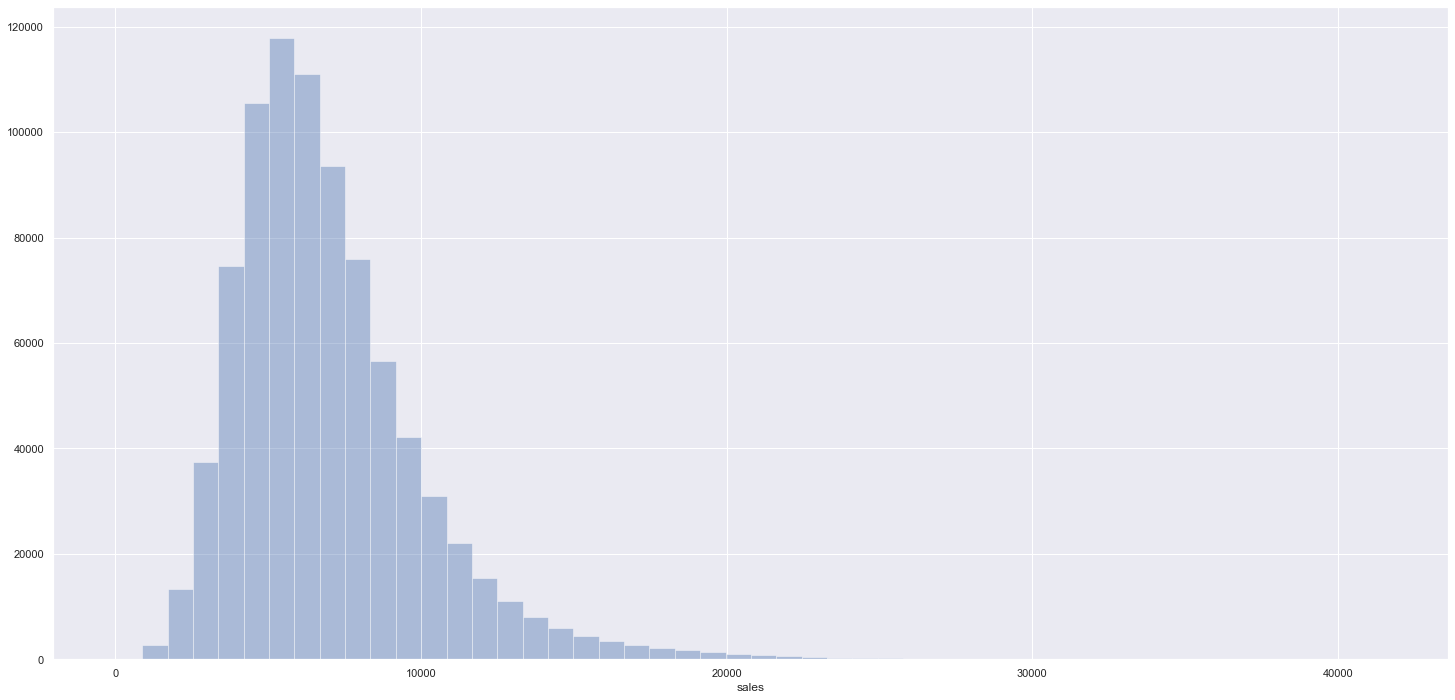

In [48]:
sns.distplot(df4['sales'], kde = False)

Sales has a slightly positive skewness.

### Numerical Variables

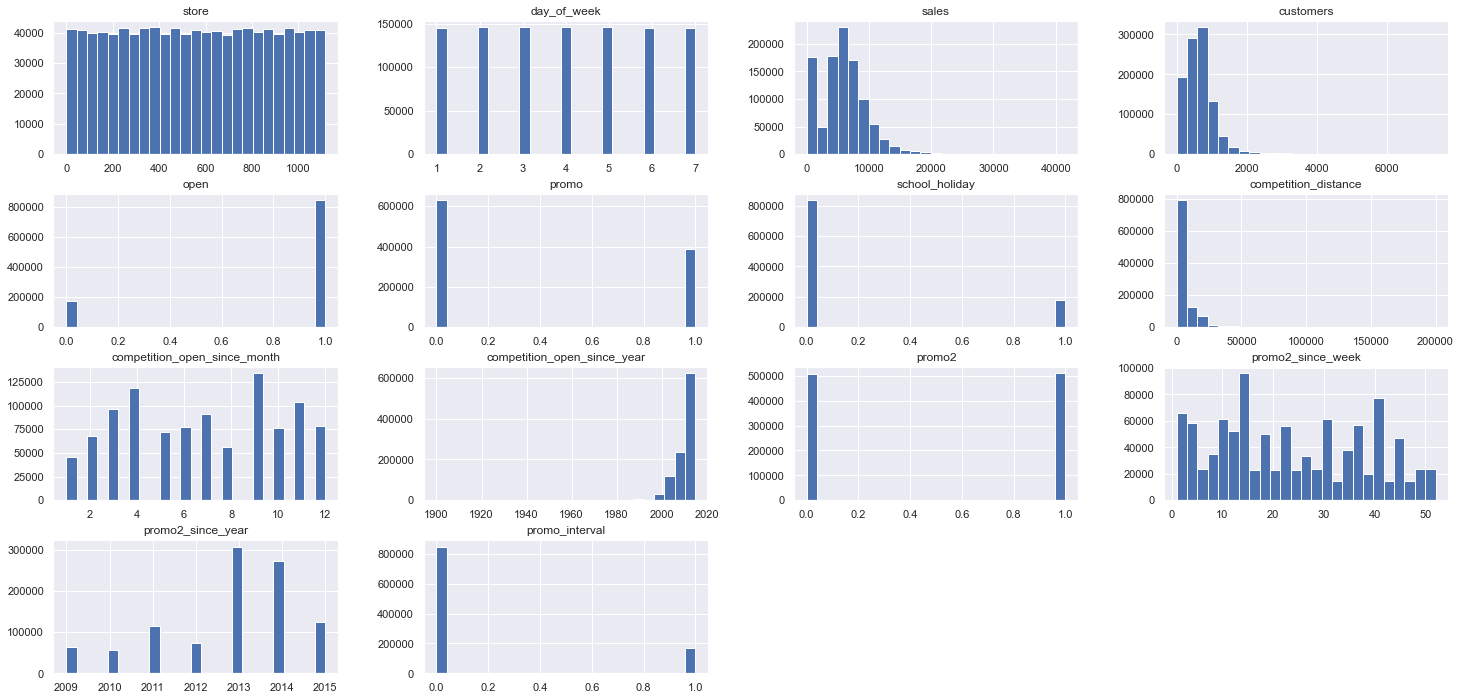

In [49]:
num_types.hist(bins = 25);

Observing the historogram for the different variables helps to establish a snapshot on some facts, like the opening of many new competitors recently, the most common daily ammount of sales is between 6 and 8 thousands euros. Most stores receive around 600-800 customers a day. The most common promotional period is arounds 14 weeks.

### Categorical Variable

['regular_day' 'public_holiday' 'easter_holiday' 'chritsmas']


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

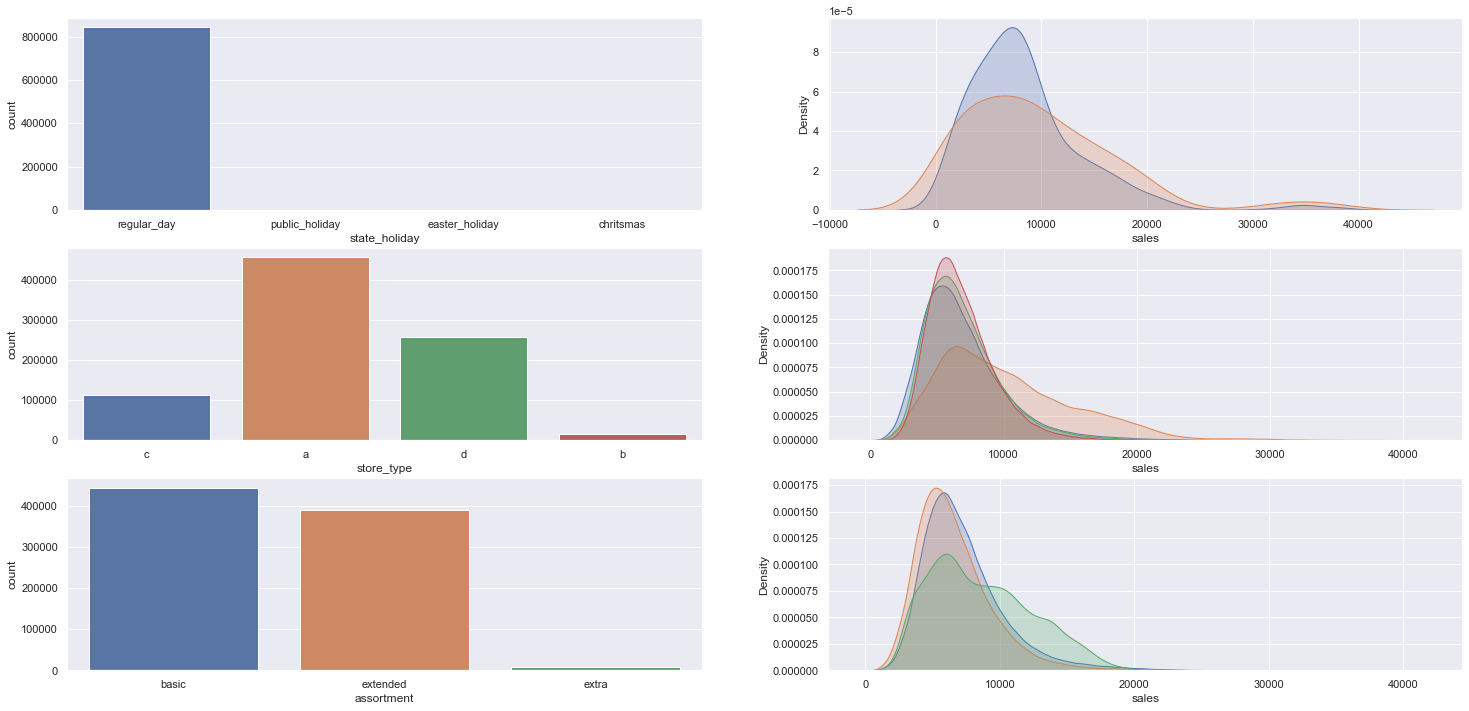

In [50]:
# state holiday
# counting
print(df4['state_holiday'].unique())
plt.subplot(3,2,1)
aa = df4[df4['state_holiday'] != 'regular day']
sns.countplot(aa['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'chrismas']['sales'], label = 'public_holiday', shade = True)

# store type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade=True)

# assortments
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True)

KDE tell us there is some kurtosis in the the data, we will treat that later on for the modeling.

## Bivariate Analysis

01 - Stores with more assortment items should sell more.

02 - Stores with more nearby competitors sell less.

03 - Stores with long time competitors should sell more.

04 - The longer the promotional period has been active the more stores should sell.

05 - Stores with more consecutive promotions should sell more.

06 - Stores open on Chrimas sell more

07 - Stores shouls sell more the throughout the years.

08 - Stores should sell more at the 2nd semester.

09 - Stores sell more after the 10th on each month.

10 - Stores sell less on weekends.

11 - Stores sell less during school holidays.


### H1 - Stores with more assortment items sell more.

In [51]:
df4.assortment.unique()

array(['basic', 'extended', 'extra'], dtype=object)

<AxesSubplot:xlabel='year_week'>

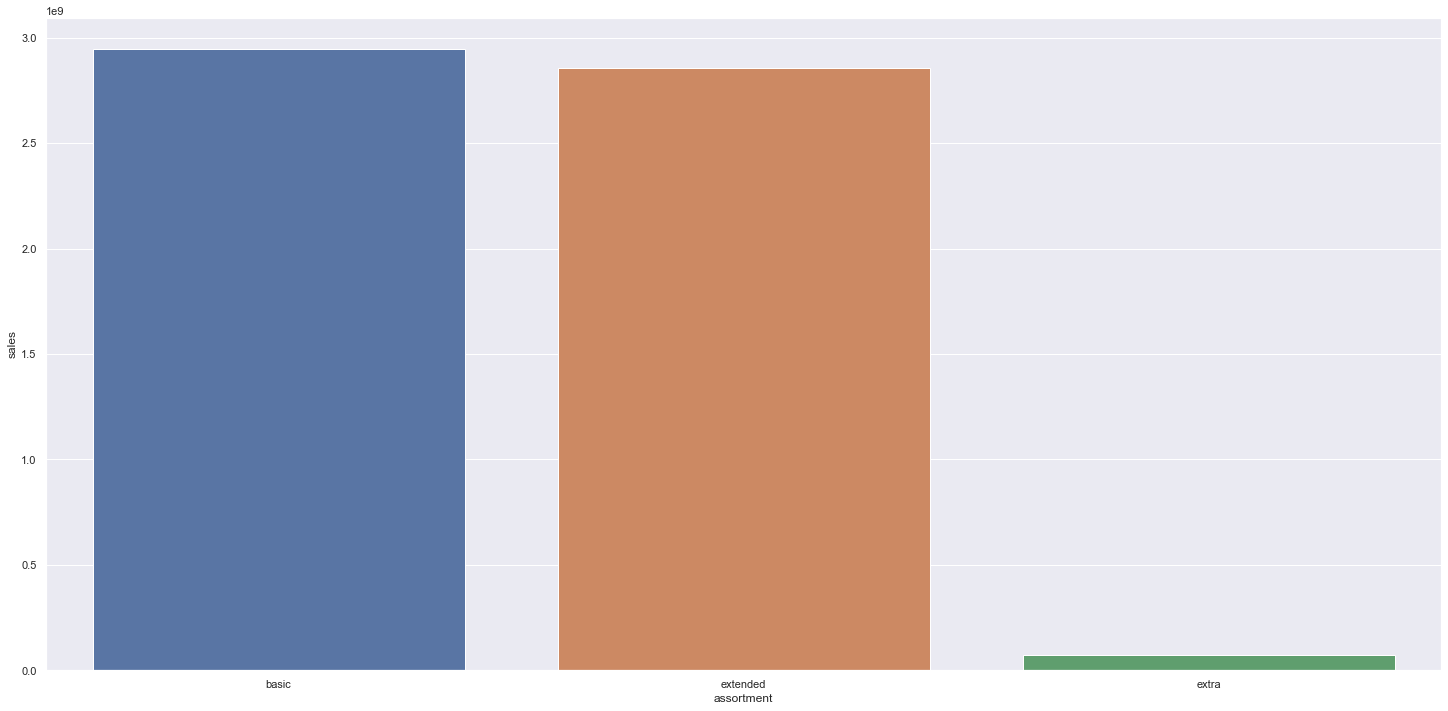

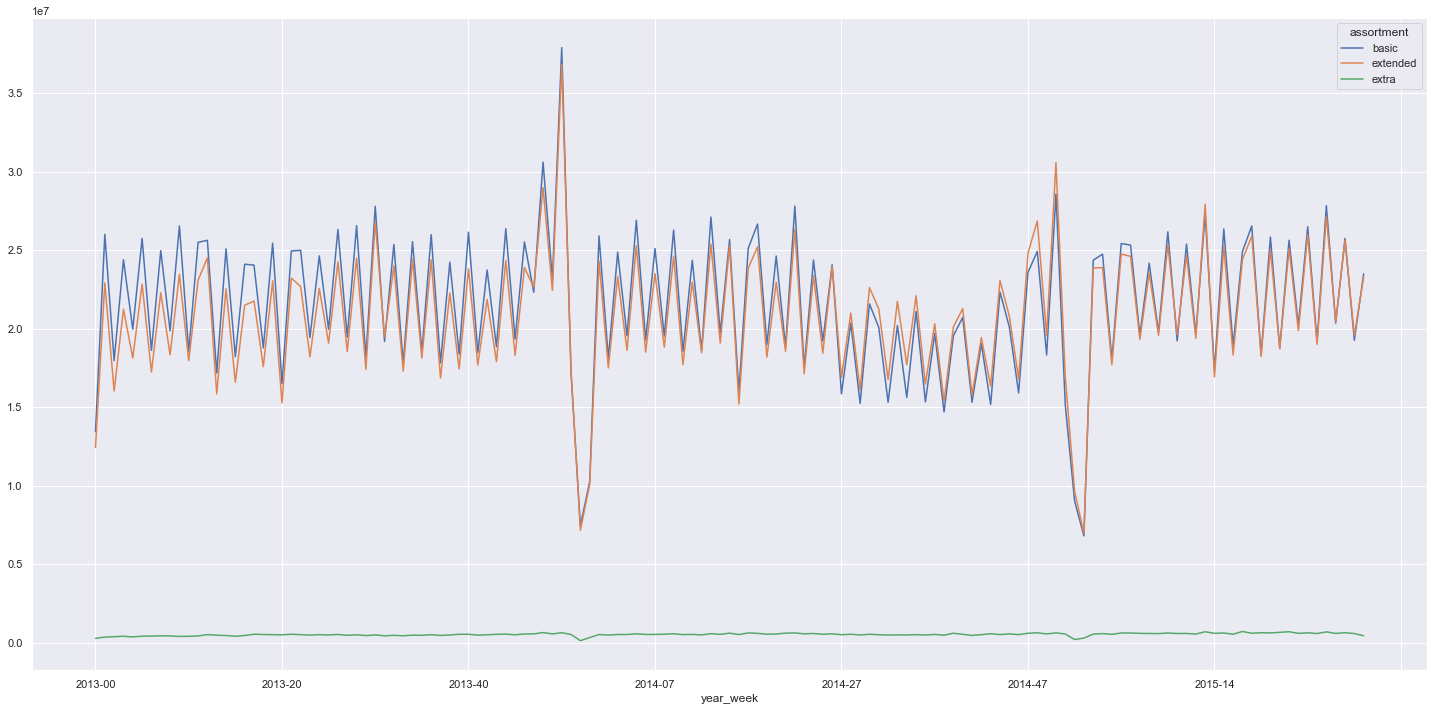

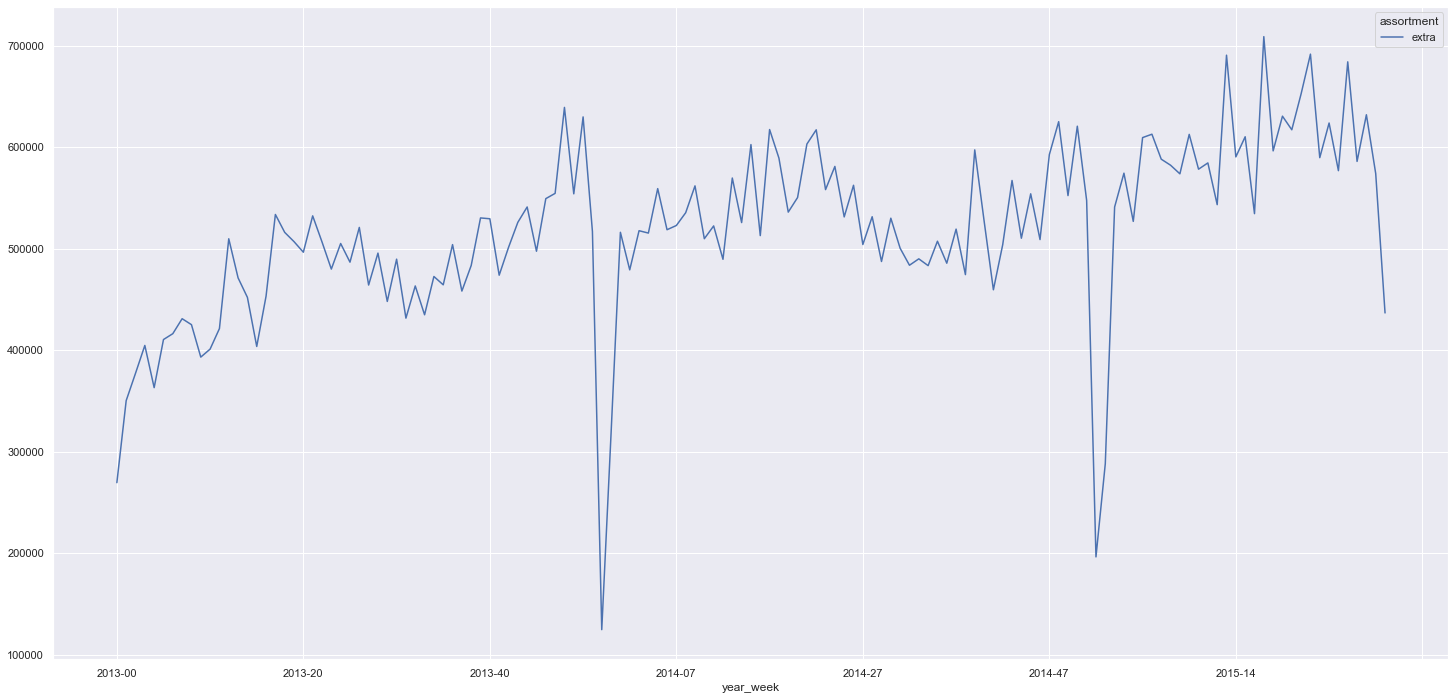

In [52]:
# plt.subplot(1,3,1)
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1)

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

aux3 = df4[df4['assortment'] == 'extra'].groupby(['year_week', 'assortment']).sum().reset_index()
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

In terms of total company revenue, the basic type of store is the one that sells the most, while the extended goes in second place, and the extra type of store represents the smaller ammount. Therefore it is possible to accept this hypothesis.

### H2 - Stores with more competitors nearby might sell less.

<AxesSubplot:>

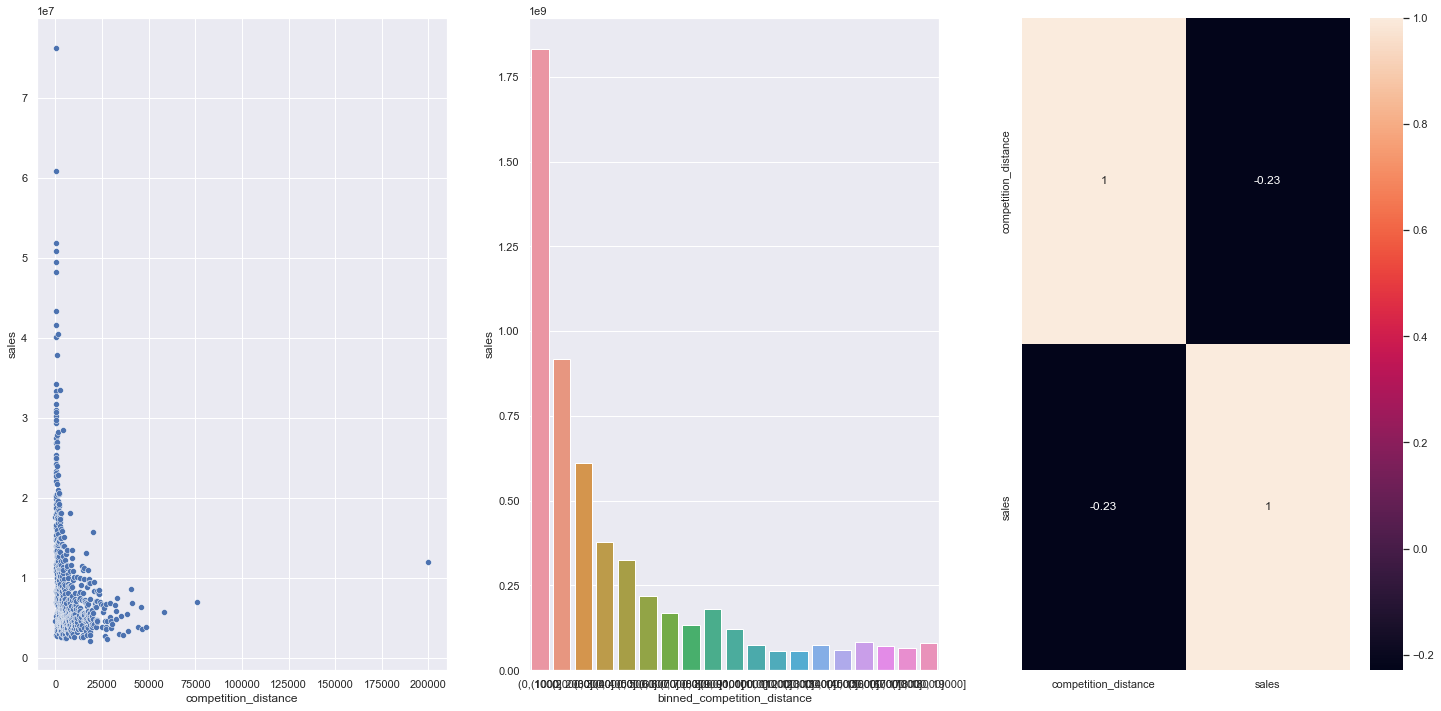

In [53]:
df4.columns

aux1 = df4[['sales', 'competition_distance']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1)

#Lets Bin the barplot

bins = list(range(0,20000,1000))
aux1['binned_competition_distance'] = pd.cut(aux1['competition_distance'], bins=bins)

aux2 = aux1[['sales','binned_competition_distance']].groupby('binned_competition_distance').sum().reset_index()
plt.subplot(1,3,2)
sns.barplot(x = 'binned_competition_distance', y = 'sales', data = aux2)

# heat map for correlation
plt.subplot(1,3,3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True)


Stores with more competitors nearby sell more, could be due to locations - rejected.

### H3 - Stores with long time competitors should sell more.

<AxesSubplot:>

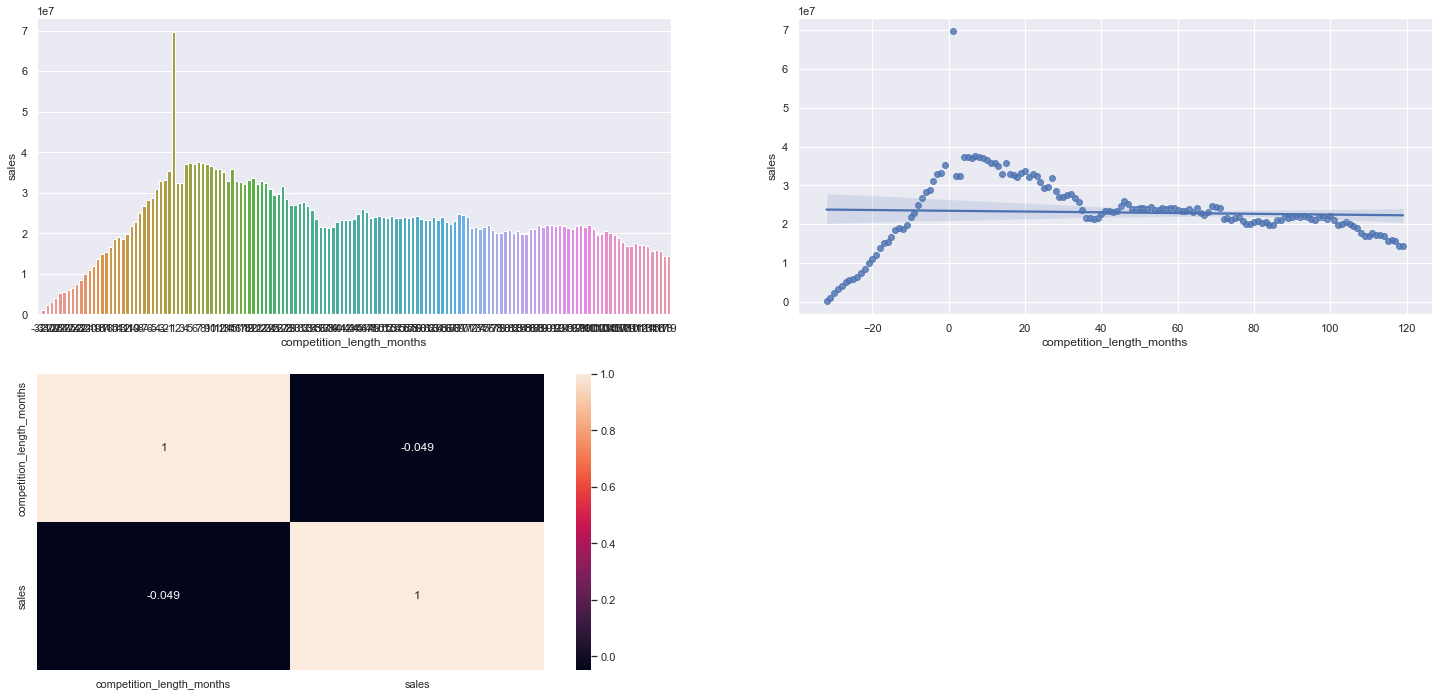

In [54]:

aux1 = df4[(df4['competition_length_months'] != 0) & (df4['competition_length_months'] < 120)]
aux1 = aux1[['competition_length_months', 'sales']].groupby('competition_length_months').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'competition_length_months', y = 'sales', data = aux1)
plt.subplot(2,2,2)
sns.regplot(data = aux1,x = 'competition_length_months', y = 'sales')
plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)


# aux1.corr(method = 'pearson')


Seems like there is an ongoing declining proccess after a competitor opens. More perceived after one year. So they sell less. Hypothesis rejected.

### H4 - The longer the promotional period has been active the more stores sell.

In [55]:
# sort(list(df4['promo_time_week'].unique()))

<AxesSubplot:>

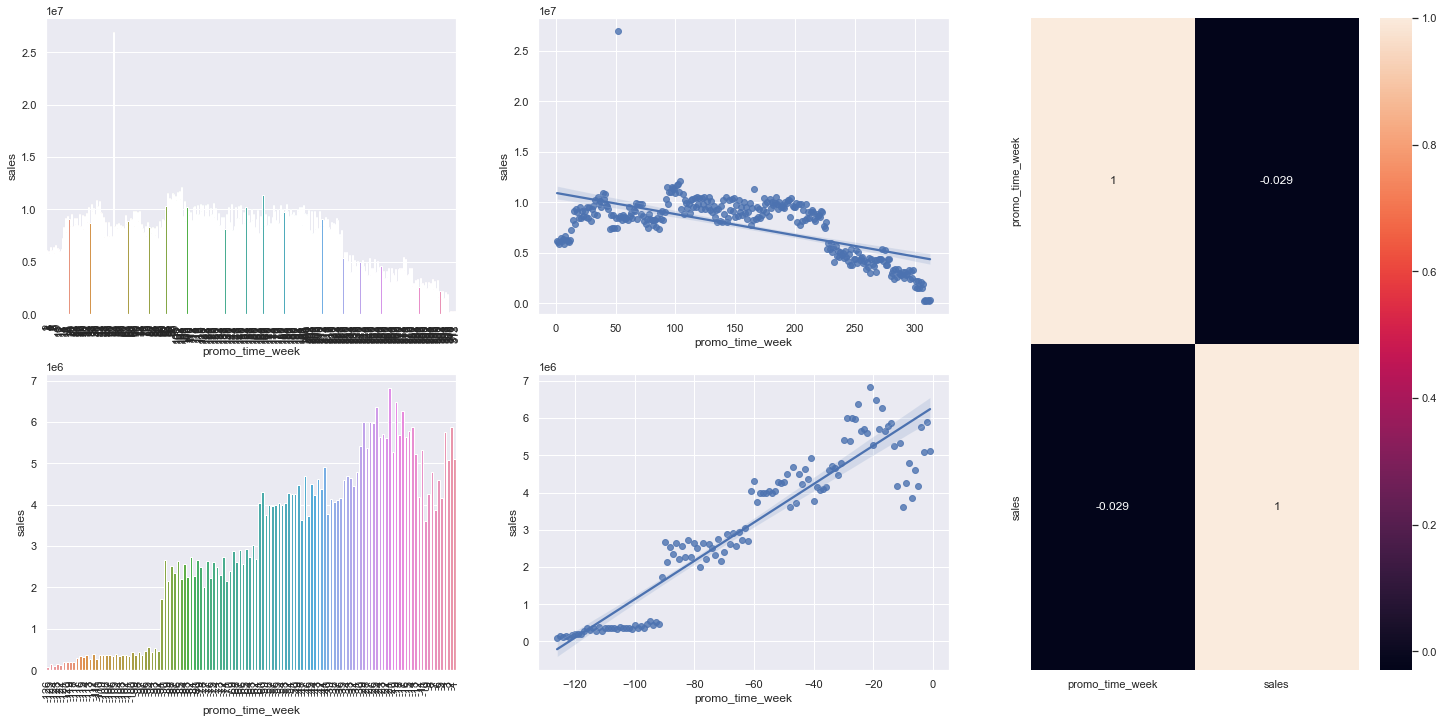

In [56]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])

aux2 = aux1[aux1['promo_time_week'] > 0] #extended promotion
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2)
plt.xticks(rotation = 90)

plt.subplot(grid[0,1])
sns.regplot(x= 'promo_time_week', y = 'sales', data = aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # regular promotion time
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3)
plt.xticks(rotation = 90)

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)



False, stores with promotion active for longer periods will sell less after a specific period of time.

### H5 - Stores with more consecutive promotions should sell more - if the store has entered a consecutive period

In [57]:
df4[['promo','promo2', 'sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


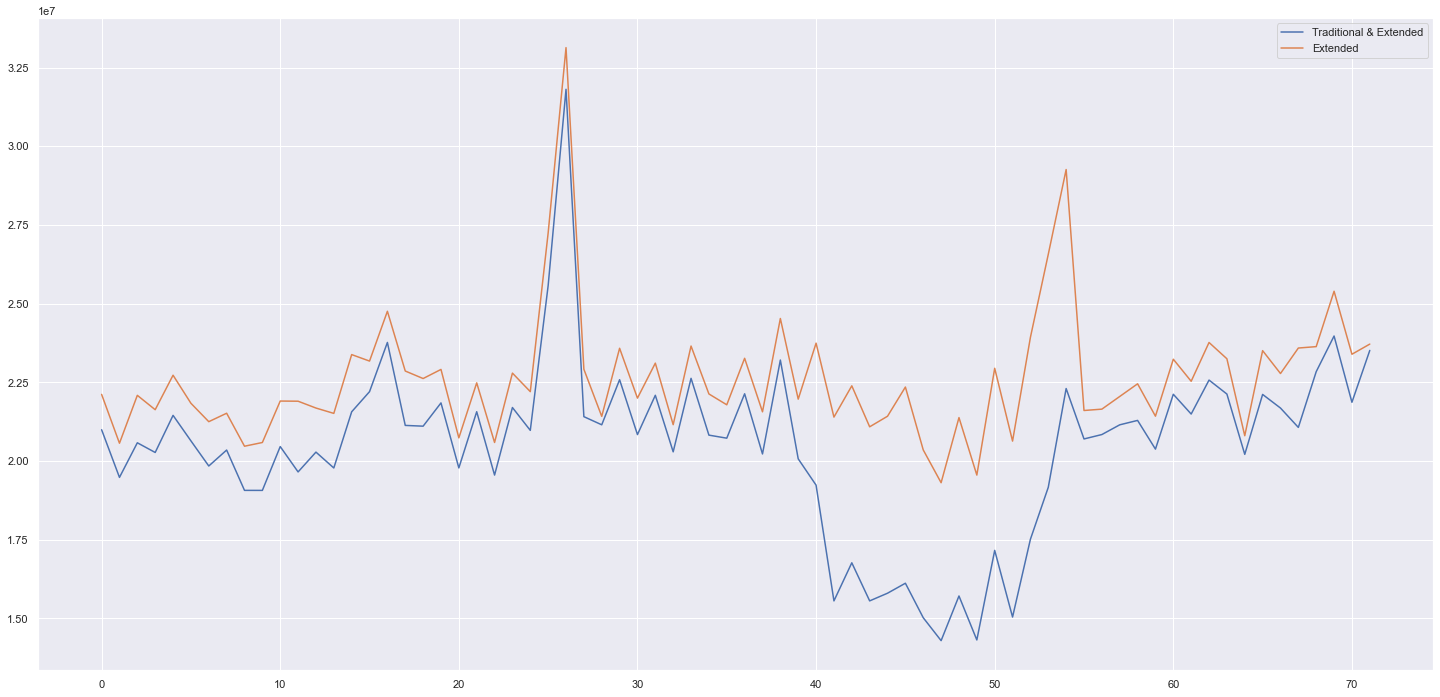

In [58]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax = ax)

ax.legend(labels = ['Traditional & Extended', 'Extended'])

The periods show to somepoint a similar behave most of the time. According to the graph we must reject the hypothesis.

### H6 - Stores open during Christmas holiday should sell more when compared to all other holidays together

<AxesSubplot:xlabel='year', ylabel='sales'>

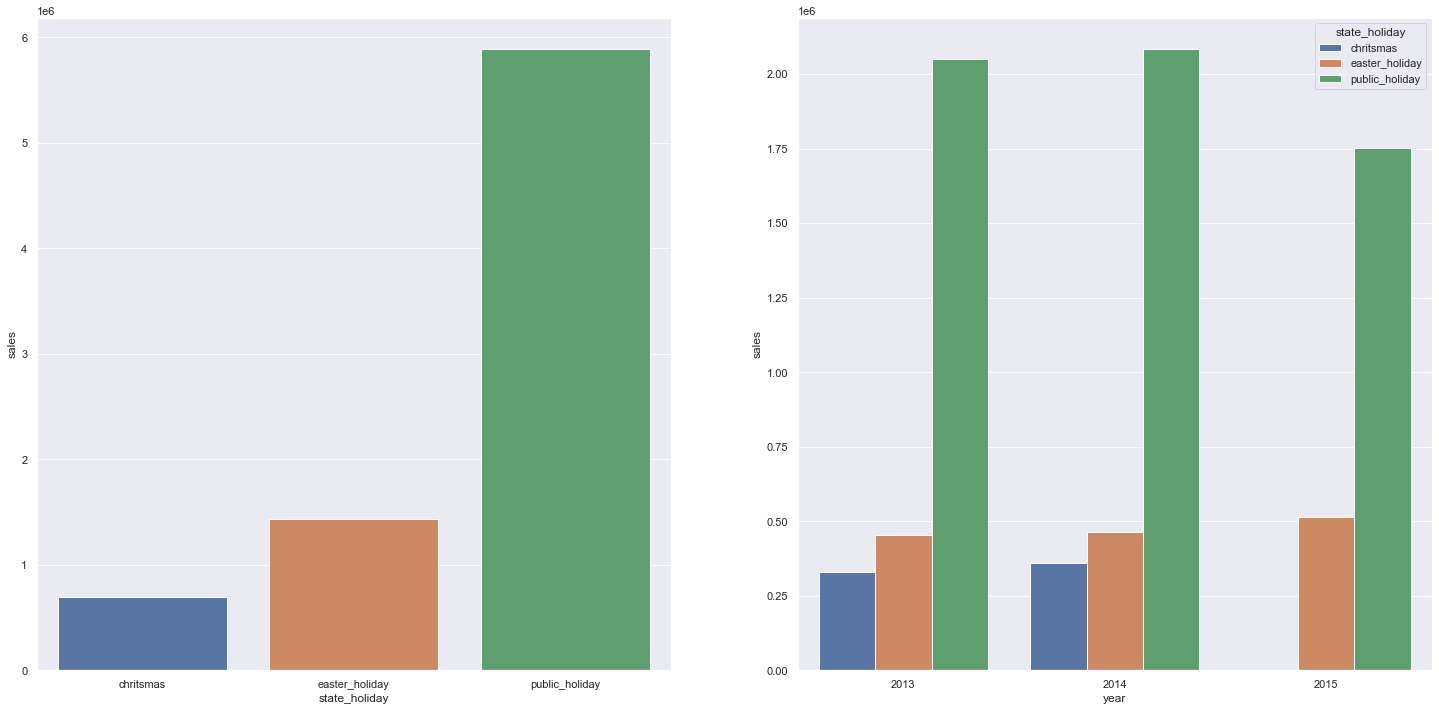

In [59]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot( x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot( x = 'year', y = 'sales', hue = 'state_holiday', data = aux2)

False, stores sell less on Chrismas, when compared to all other holidays.

### H7 - Stores throught the years should sell more.

<AxesSubplot:>

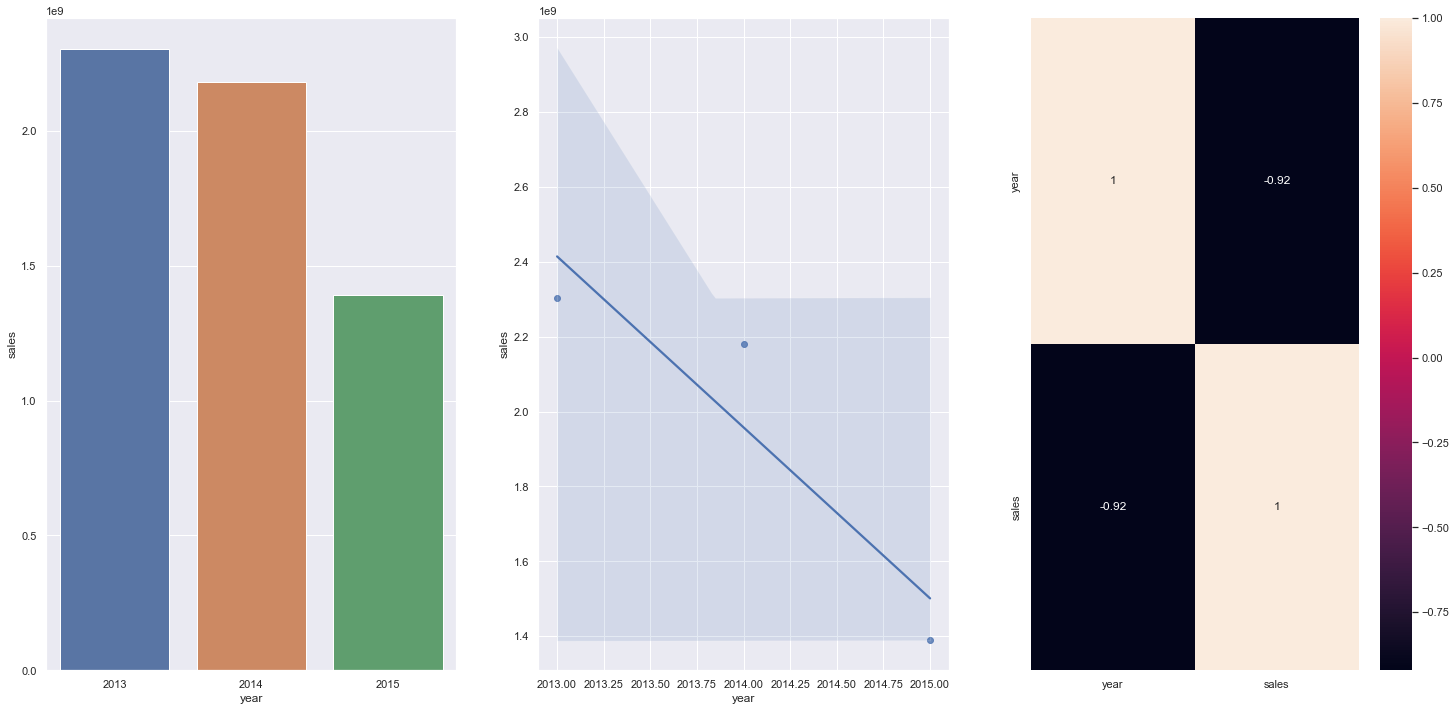

In [60]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x = 'year', y ='sales', data = aux1)

plt.subplot(1, 3, 2)
sns.regplot( x = 'year', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

Not true, there is an ongoing declining proccess. Rejected.

### H8 - Stores sell more at the second semester

<AxesSubplot:>

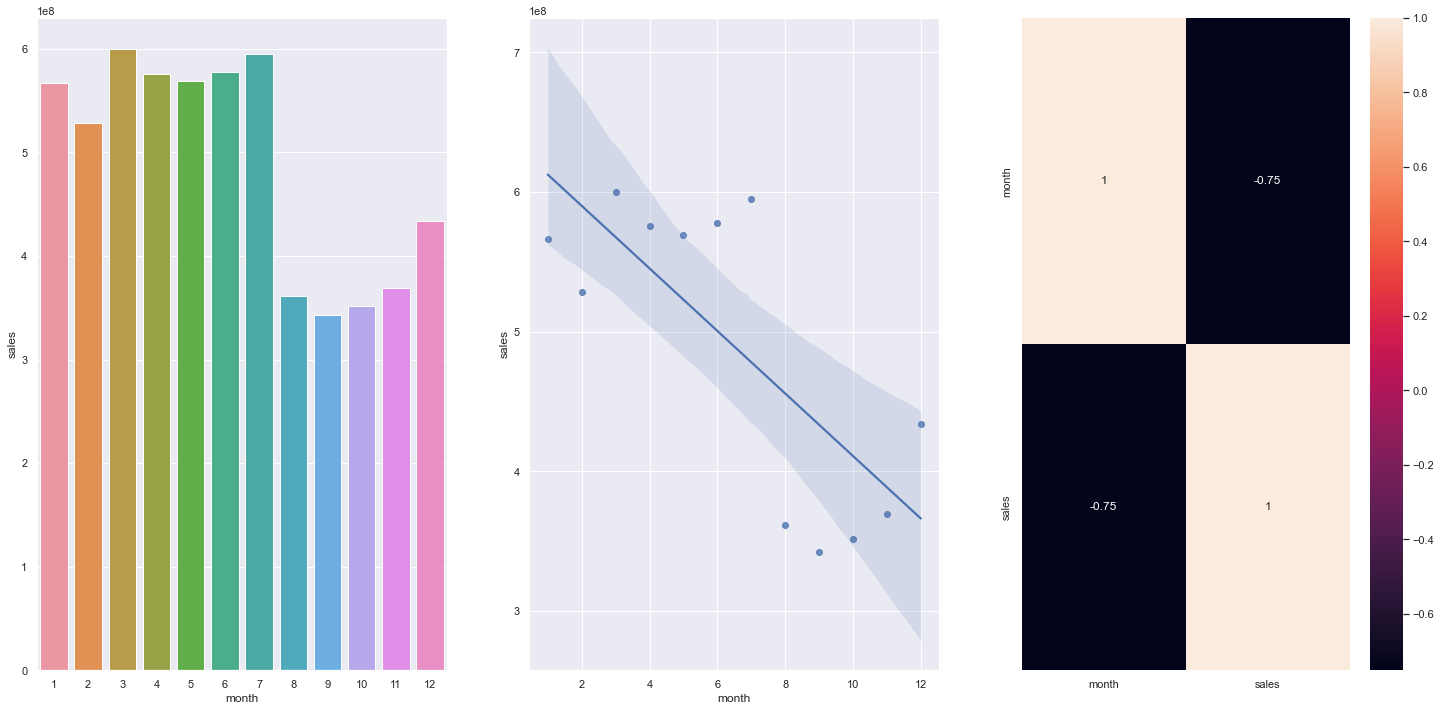

In [61]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'month', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.regplot(x = 'month', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

Not true, the first semester is the time when stores sells more. Rejected.

### H9 - Stores should sell more after the 10th of each month.

<AxesSubplot:xlabel='before_after', ylabel='sales'>

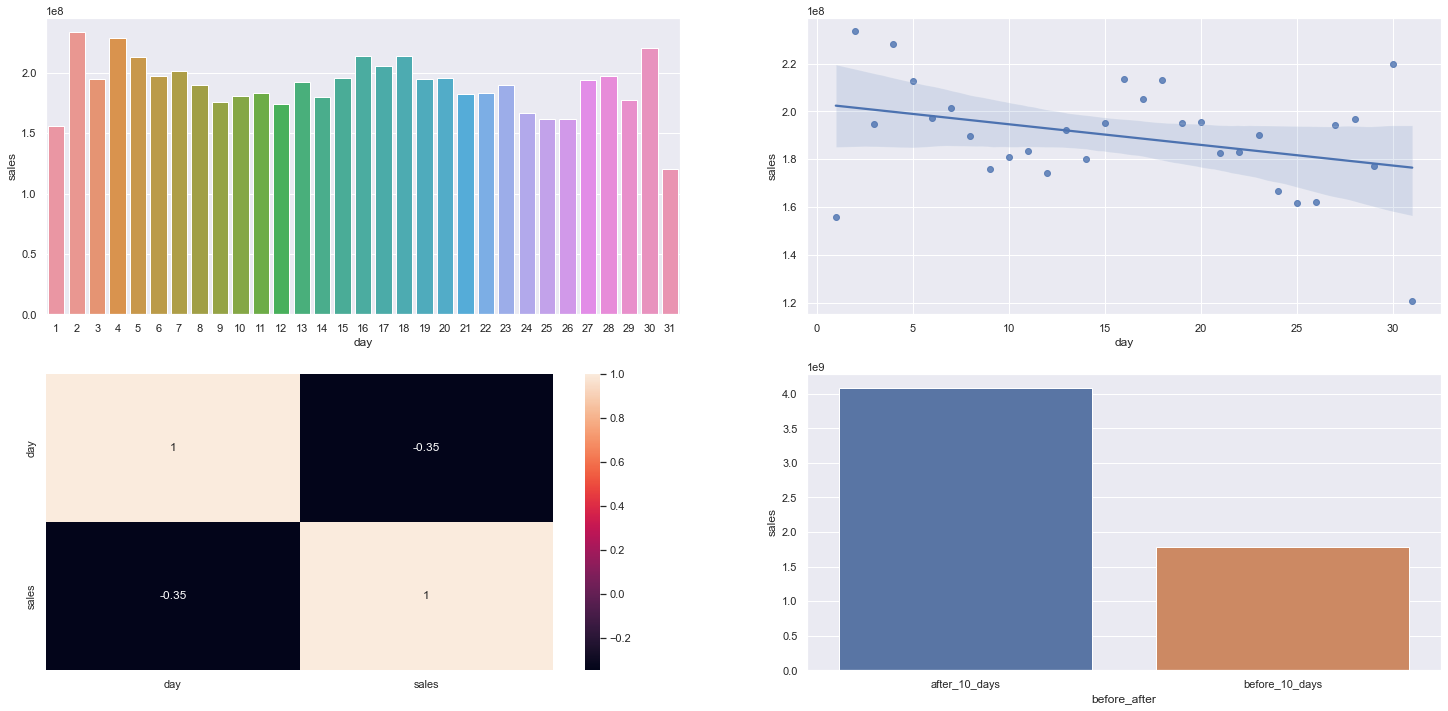

In [62]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day', y = 'sales', data = aux1)

plt.subplot(2,2,2)
sns.regplot(x = 'day', y = 'sales', data = aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x < 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x = 'before_after', y='sales', data=aux2)


They sell more before the 10th of each month. Rejected.

### H10 - Stores should sell less on weekends

<AxesSubplot:>

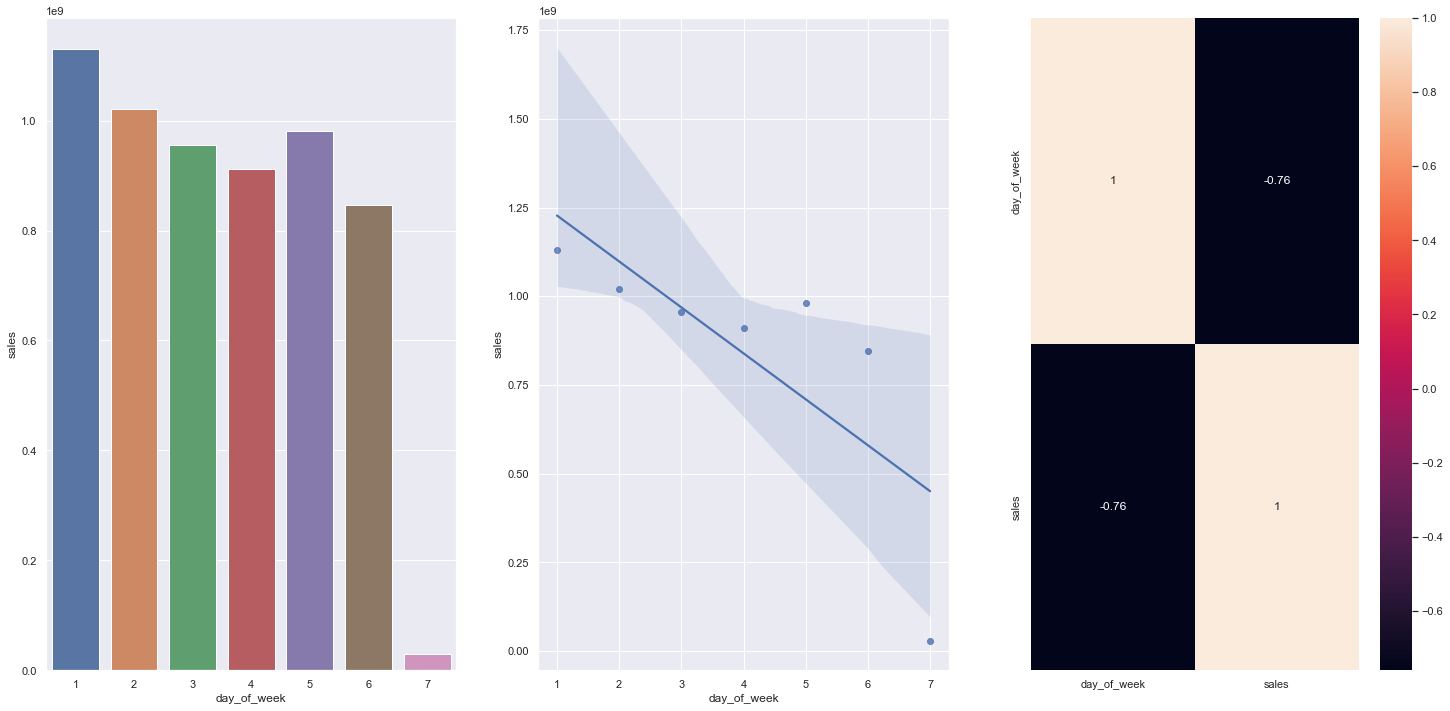

In [63]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot( x = 'day_of_week', y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)


Not true.

### H11 - Stores should sell less during school holidays

<AxesSubplot:xlabel='month', ylabel='sales'>

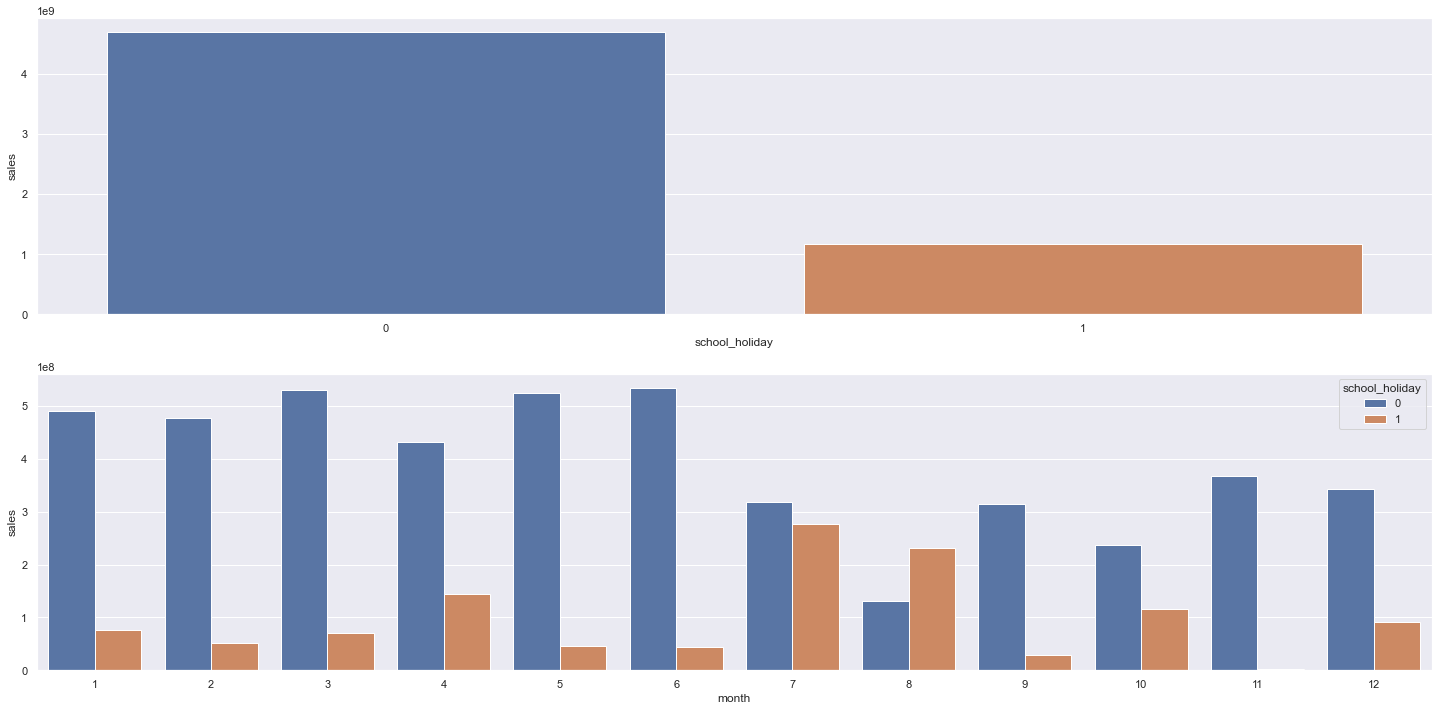

In [64]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1)

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot( x = 'month', y ='sales', hue = 'school_holiday', data = aux2)


### Summary Hypothesis

In [65]:
from tabulate import tabulate
tab = [['H#','Result', 'Hypothesis', 'Relevance'],
       ['H01', 'True','Stores with more assortment items sell more','High'],
       ['H02', 'False','Stores with more compretitors nearby sell less', 'High'],
       ['H03', 'False','Store with long time compretitors sell more', 'Low'],
       ['H04', 'False','The longer the promotional perios has been active the more stores sell','Low'],
       ['H05', 'False','Stores with more consecutive promotions should sell more if the store has entered a consecutive period','Low'],
       ['H06', 'False','Stores open on Chrismas sell more when compared to all other holidays together','High'],
       ['H07', 'False','Stores throught the years should sell more','High'],
       ['H08', 'False','Stores sell more at the second semester','High'],
       ['H09', 'False','Stores should sell more after the 10th of each month','High'],
       ['H10', 'False','Stores should sell more on weekends','High'],
       ['H11', 'True','Stores should sell less during school holidays','High'],
      ]
print(tabulate(tab, headers = 'firstrow'))



H#    Result    Hypothesis                                                                                              Relevance
----  --------  ------------------------------------------------------------------------------------------------------  -----------
H01   True      Stores with more assortment items sell more                                                             High
H02   False     Stores with more compretitors nearby sell less                                                          High
H03   False     Store with long time compretitors sell more                                                             Low
H04   False     The longer the promotional perios has been active the more stores sell                                  Low
H05   False     Stores with more consecutive promotions should sell more if the store has entered a consecutive period  Low
H06   False     Stores open on Chrismas sell more when compared to all other holidays together                      

## Multivariate analysis

### Numerical Attribytes:

<AxesSubplot:>

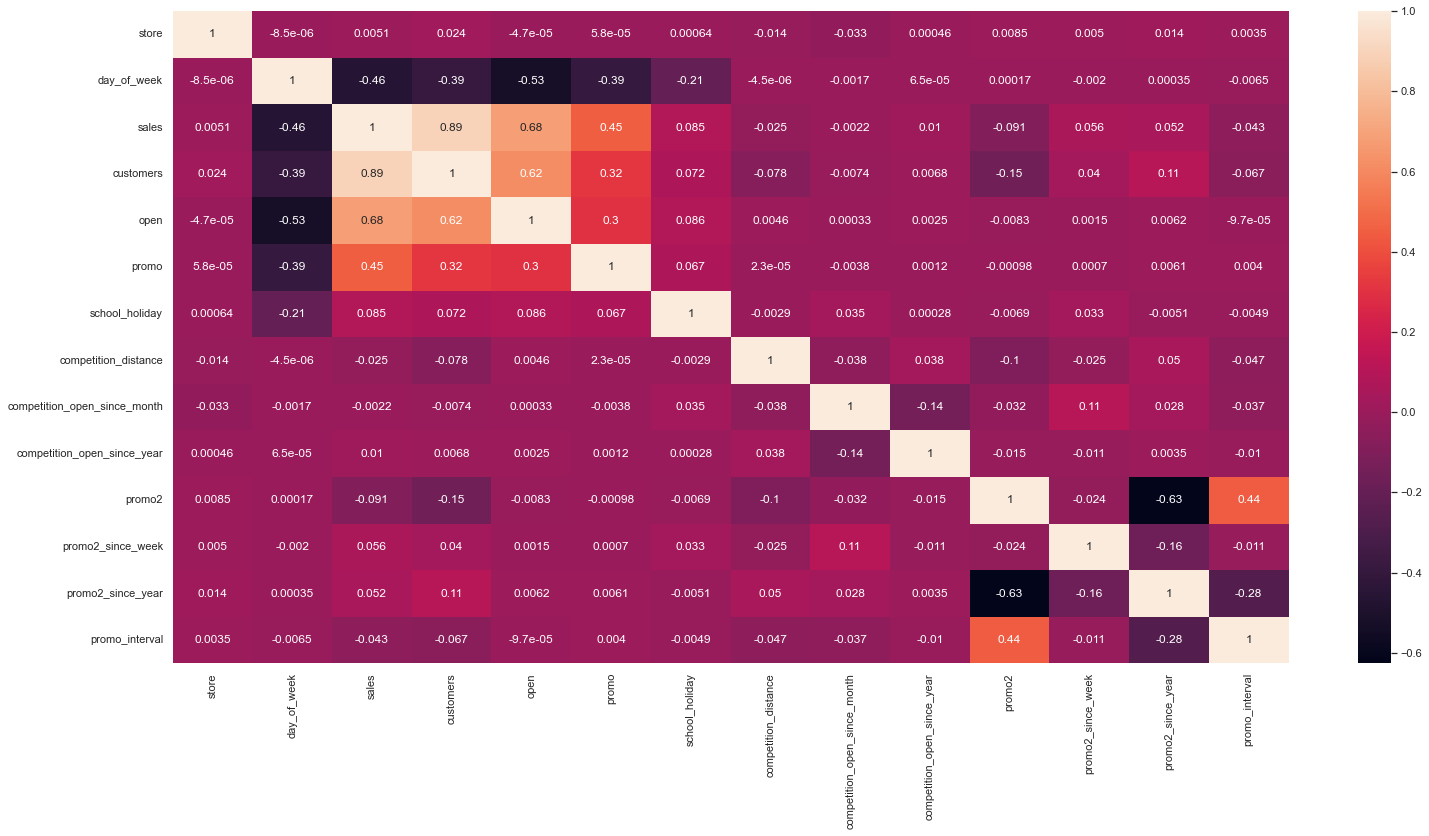

In [66]:
correlation = num_types.corr(method = 'pearson')
sns.heatmap(correlation, annot = True)

### Categorical Attributes - cramer method

<AxesSubplot:>

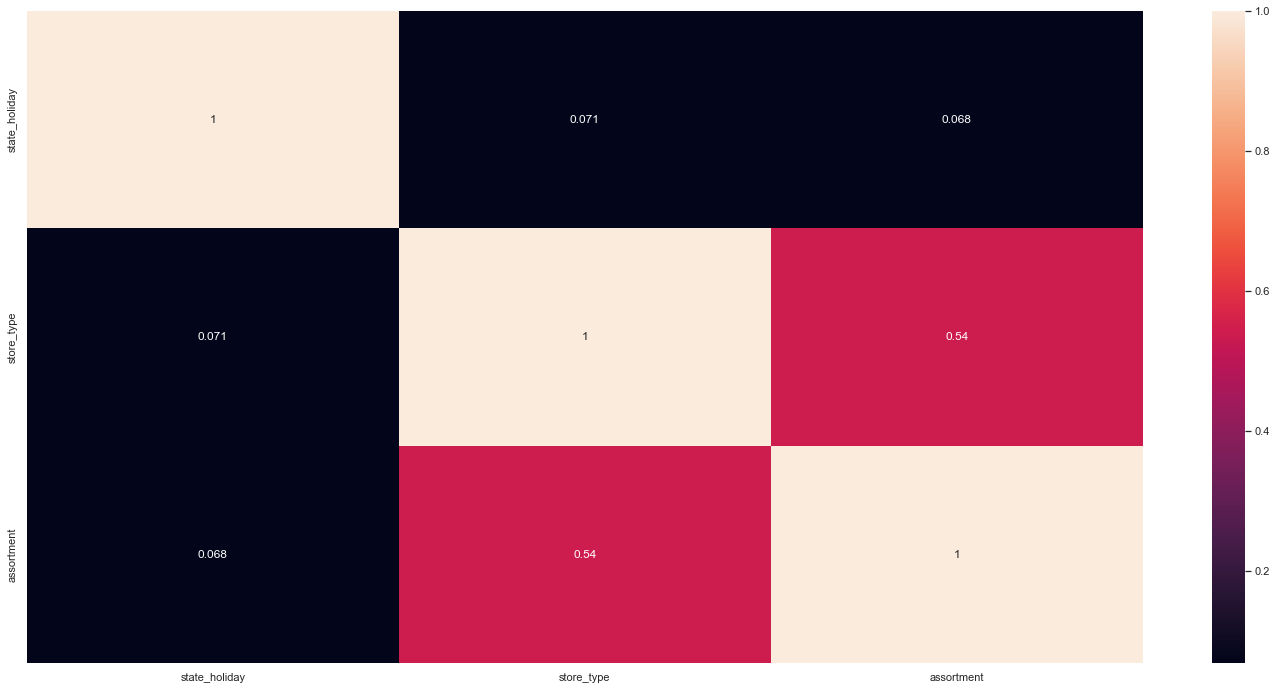

In [67]:
#select categorical data
a = df4.select_dtypes( include = 'object')

# do cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final Dataset:

d = pd.DataFrame( {'state_holiday':[a1,a2,a3],
                  'store_type':[a4,a5,a6],
                  'assortment':[a7,a8,a9] })

d = d.set_index(d.columns)
sns.heatmap(d, annot = True)



In [68]:
df4.to_pickle('04.pkl')

## Data Preparation

In [69]:
df5 = df4.copy()

### Normalization

In [70]:
# There is no normal distribution by looking at the univariate analysis.

### Rescaling

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

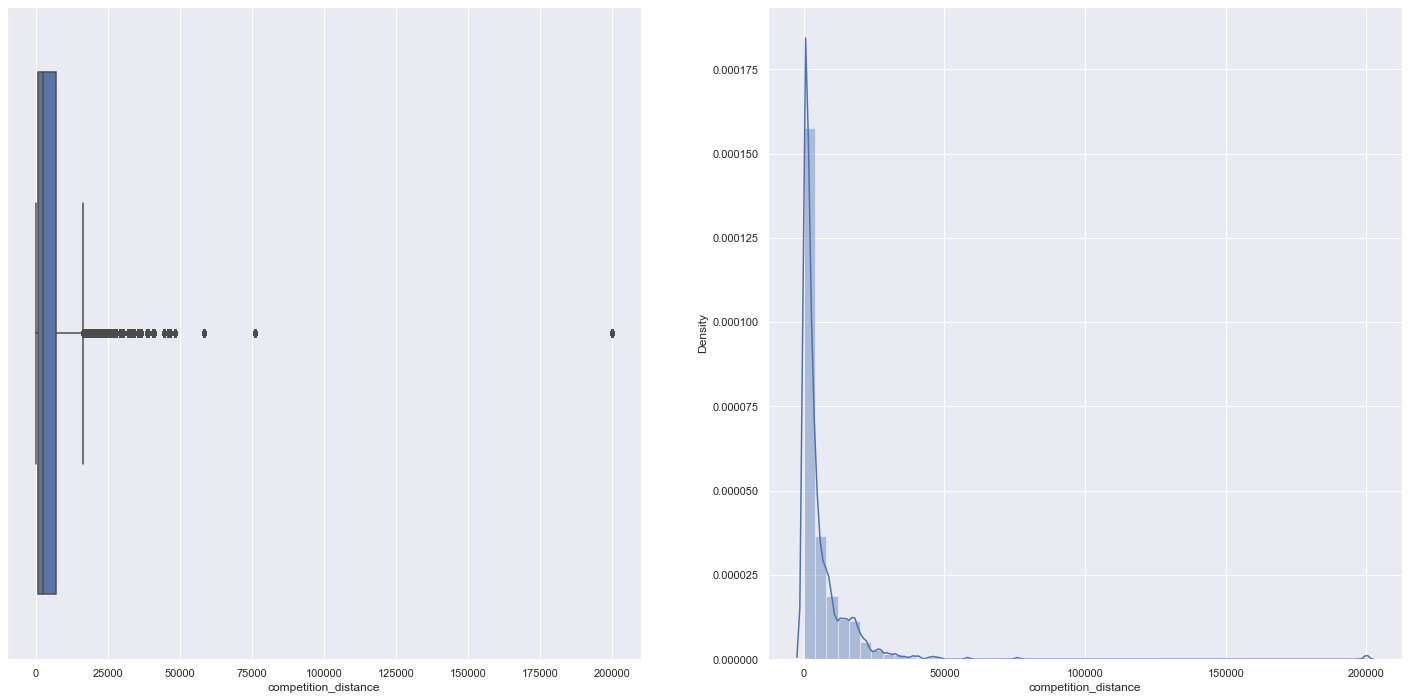

In [71]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
plt.subplot(1,2, 1)
sns.boxplot(df5['competition_distance'])
plt.subplot(1,2, 2)
sns.distplot(df5['competition_distance'])

In [72]:
# rescaling  competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump( rs, open( './competition_distance_scaler.pkl', 'wb') )

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

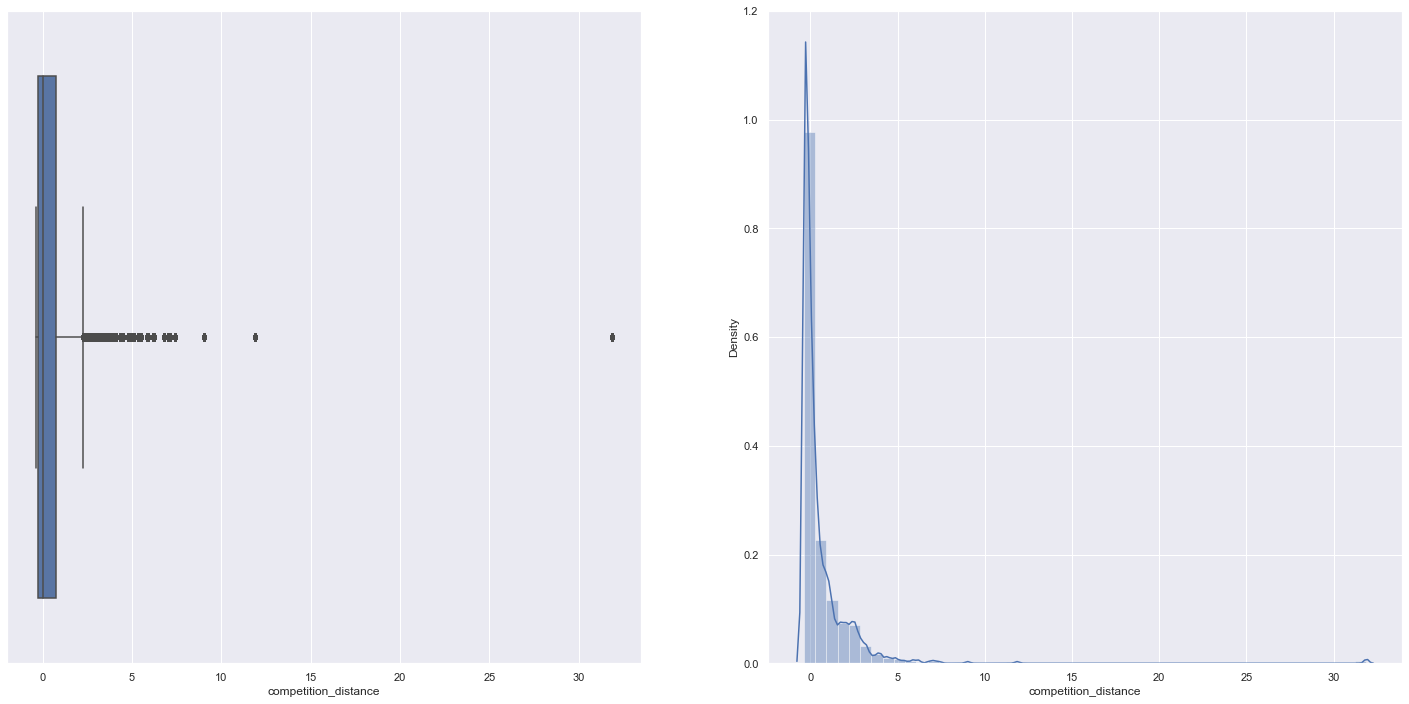

In [73]:
plt.subplot(1,2, 1)
sns.boxplot(df5['competition_distance'])
plt.subplot(1,2, 2)
sns.distplot(df5['competition_distance'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_length_months', ylabel='Density'>

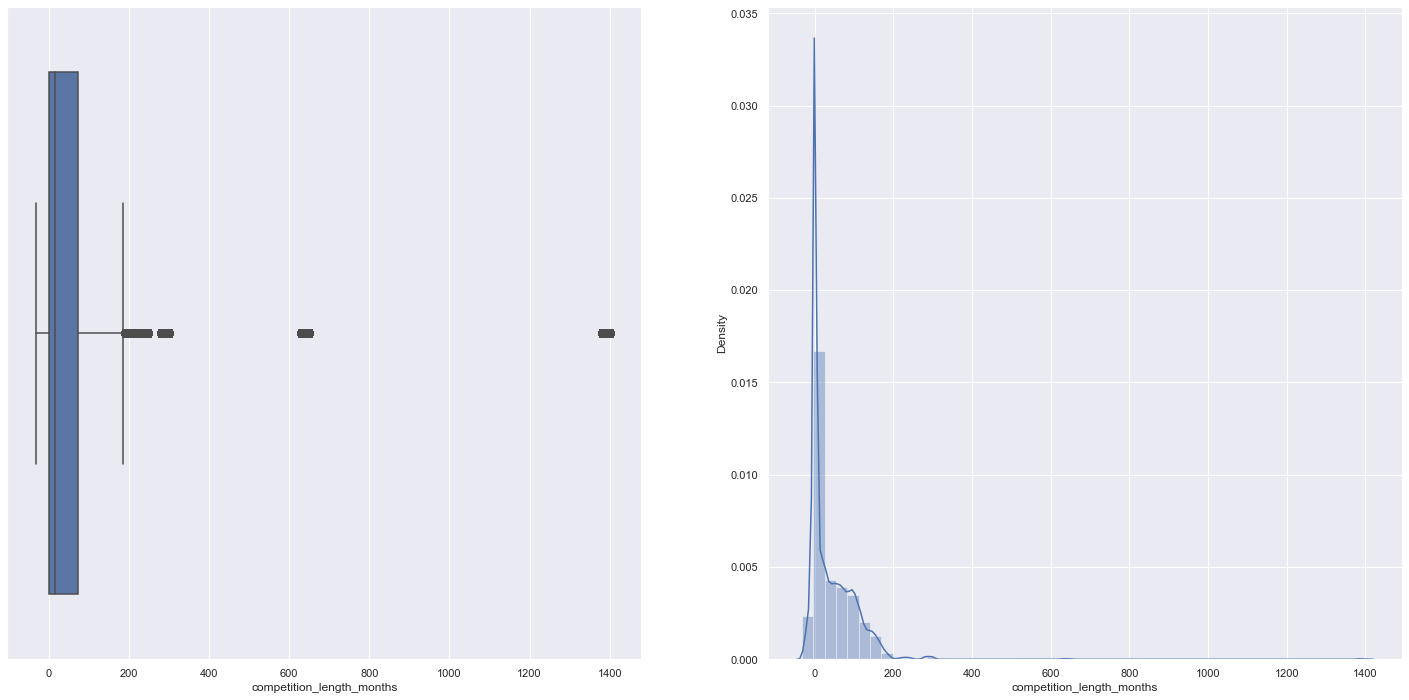

In [74]:
plt.subplot(1,2, 1)
sns.boxplot(df5['competition_length_months'])
plt.subplot(1,2, 2)
sns.distplot(df5['competition_length_months'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_length_months', ylabel='Density'>

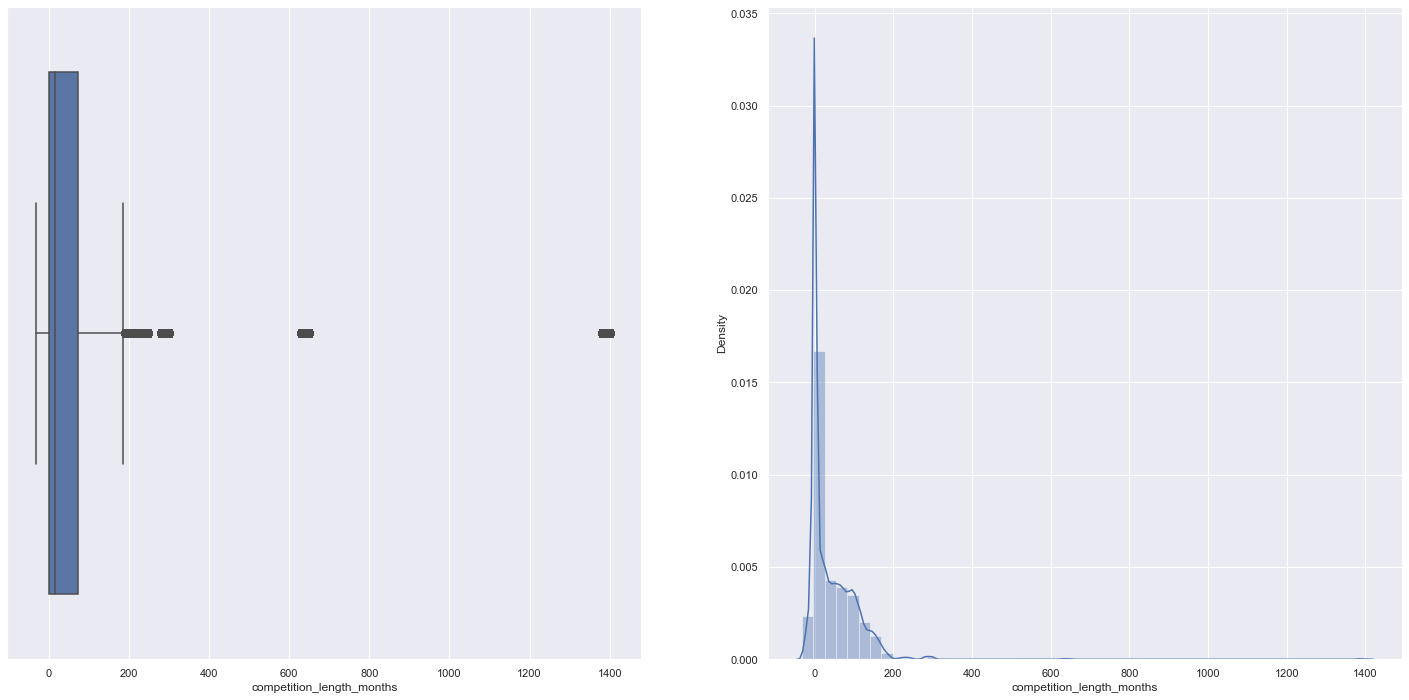

In [75]:
#competition time month
# rescaling
df5['competition_time_month'] = rs.fit_transform(df5[['competition_length_months']])
pickle.dump( rs, open( './competition_time_month_scaler.pkl', 'wb') )
plt.subplot(1,2, 1)
sns.boxplot(df5['competition_length_months'])
plt.subplot(1,2, 2)
sns.distplot(df5['competition_length_months'])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='promo_time_week', ylabel='Density'>

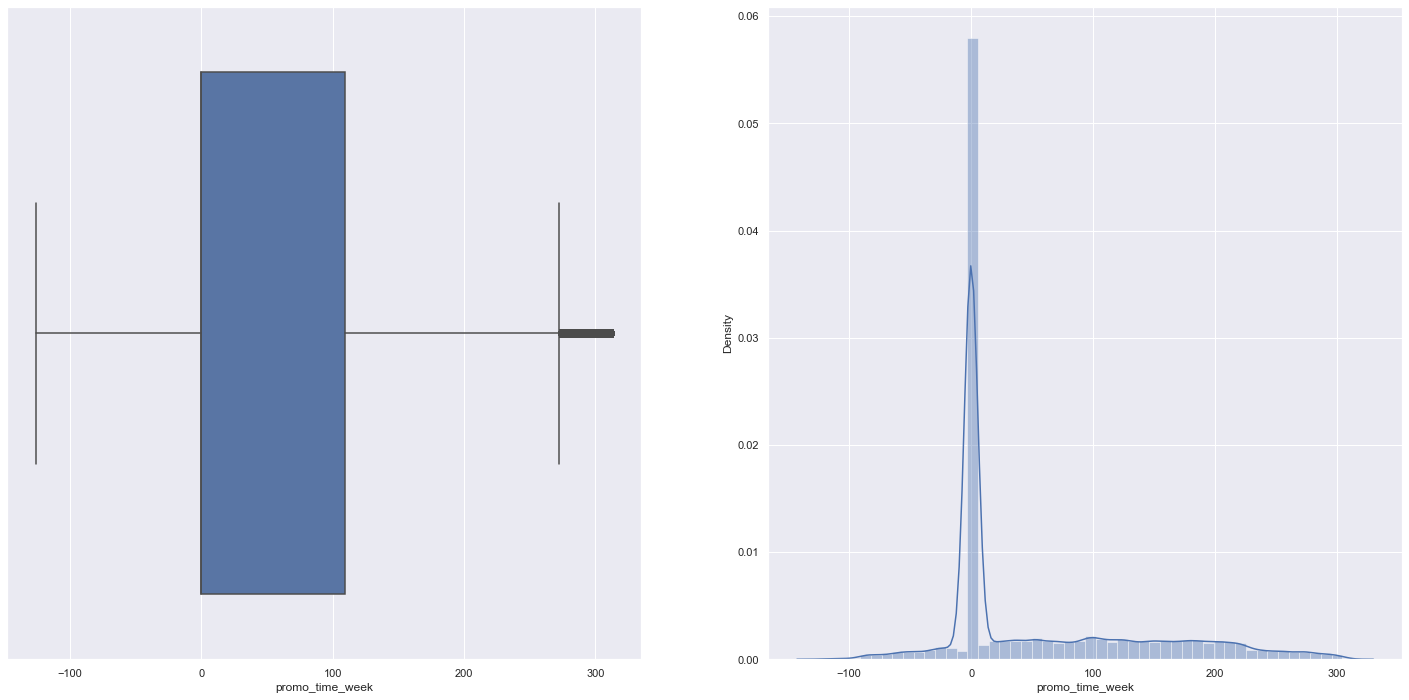

In [76]:
plt.subplot(1,2, 1)
sns.boxplot(df5['promo_time_week'])
plt.subplot(1,2, 2)
sns.distplot(df5['promo_time_week'])

In [77]:
# promo time week rescaling
df5.promo_time_week = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump( mms, open( './promo_time_week_scaler.pkl', 'wb') )


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='promo_time_week', ylabel='Density'>

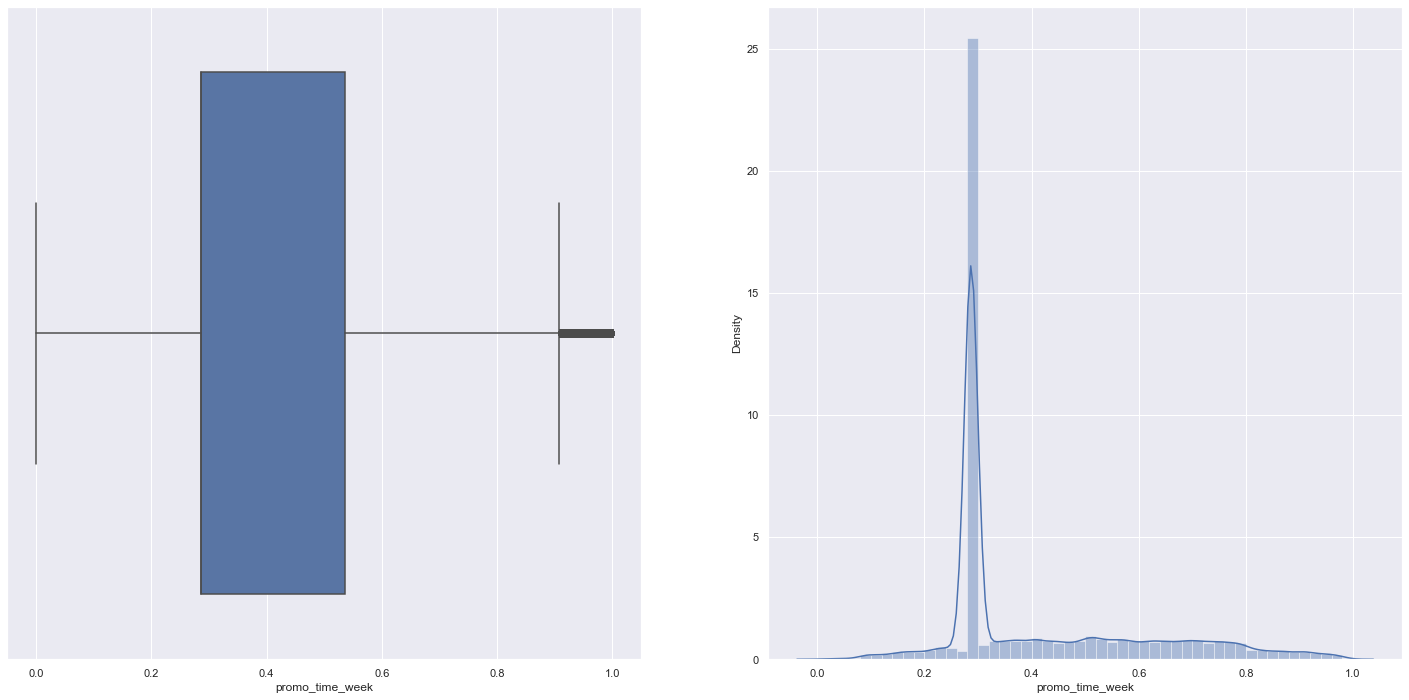

In [78]:
plt.subplot(1,2, 1)
sns.boxplot(df5['promo_time_week'])
plt.subplot(1,2, 2)
sns.distplot(df5['promo_time_week'])

In [79]:
# year
# rescaling
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump( mms, open( './year_scaler.pkl', 'wb') )

### Transformation 

#### Encoding - Tranform num variable cyclical nature


In [80]:
# state holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix =['state_holiday'], columns =['state_holiday'])

In [81]:
df5.head(3)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,year,month,day,week_of_year,year_week,competition_since,competition_length_months,promo_since,promo_time_week,competition_time_month,state_holiday_chritsmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,c,basic,-0.170968,9,2008,0,31,2015,1.0,7,31,31,2015-30,2008-09-01,84,2015-07-27,0.287016,0.918919,0,0,0,1
1,2,5,2015-07-31,6064,1,1,a,basic,-0.283871,11,2007,1,13,2010,1.0,7,31,31,2015-30,2007-11-01,94,2010-03-22,0.922551,1.054054,0,0,0,1
2,3,5,2015-07-31,8314,1,1,a,basic,1.903226,12,2006,1,14,2011,1.0,7,31,31,2015-30,2006-12-01,105,2011-03-28,0.801822,1.202703,0,0,0,1


In [82]:
# Store type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump( le, open( './store_type_scaler.pkl', 'wb', pickle.HIGHEST_PROTOCOL) )

In [83]:
df5.head(3)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,year,month,day,week_of_year,year_week,competition_since,competition_length_months,promo_since,promo_time_week,competition_time_month,state_holiday_chritsmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,basic,-0.170968,9,2008,0,31,2015,1.0,7,31,31,2015-30,2008-09-01,84,2015-07-27,0.287016,0.918919,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,basic,-0.283871,11,2007,1,13,2010,1.0,7,31,31,2015-30,2007-11-01,94,2010-03-22,0.922551,1.054054,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,basic,1.903226,12,2006,1,14,2011,1.0,7,31,31,2015-30,2006-12-01,105,2011-03-28,0.801822,1.202703,0,0,0,1


In [84]:
#assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [85]:
df5.head(3)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,year,month,day,week_of_year,year_week,competition_since,competition_length_months,promo_since,promo_time_week,competition_time_month,state_holiday_chritsmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,1.0,7,31,31,2015-30,2008-09-01,84,2015-07-27,0.287016,0.918919,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1.0,7,31,31,2015-30,2007-11-01,94,2010-03-22,0.922551,1.054054,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1.0,7,31,31,2015-30,2006-12-01,105,2011-03-28,0.801822,1.202703,0,0,0,1


#### Response Variable Transformation

In [86]:
df5['sales'] = np.log1p(df5['sales'])

In [87]:
df5.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                  float64
promo                                    int64
school_holiday                           int64
store_type                               int32
assortment                               int64
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
year                                   float64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
competition_since               datetime64[ns]
competition_length_months                int32
promo_since  

#### Nature Transformation

In [88]:
# day of the week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2. * np.pi/7)))

#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2. * np.pi/12)))

# day
df5['day_sin'] = df5['month'].apply(lambda x: np.sin(x*(2. * np.pi/30)))
df5['day_cos'] = df5['month'].apply(lambda x: np.cos(x*(2. * np.pi/30)))

#week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2. * np.pi/52)))






In [89]:
df5.to_pickle('05.pkl')

# Feature Selection

In [90]:
df6 = df5.copy()

## Split dataframe into training and test dataset

In [91]:
# training dataset
cols_drop = ['week_of_year', 'day', 'month', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1)


In [92]:
# test dataset
# 6 weeks...
# till where dataset goes...
# the need to take out some information in order to check the model accuracy
# otherwise 'model already knows that information' - so it will know 'the future'

df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 7 * 6) # (7 dias vezes 6 semanas)




Timestamp('2015-06-19 00:00:00')

In [93]:
df6.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'school_holiday',
       'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'year',
       'competition_length_months', 'promo_time_week',
       'competition_time_month', 'state_holiday_chritsmas',
       'state_holiday_easter_holiday', 'state_holiday_public_holiday',
       'state_holiday_regular_day', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos'],
      dtype='object')

In [94]:
# this is the training dataset:
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset:
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']


print('Trainint Min Date: {}'.format(X_train['date'].min()))
print('Trainint Max Date: {}'.format(X_train['date'].max()))
print('\n Test Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))



Trainint Min Date: 2013-01-01 00:00:00
Trainint Max Date: 2015-06-18 00:00:00

 Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## Boruta as feature selector

In [95]:
# Training and testing datasets for Borura

X_train.head()
X_train_n = X_train.drop(['date','sales'], axis =1).values # get only values,getting a numpy
y_train_n = y_train.values.ravel()  # ravel puts everything inside a vector

X_train.columns


Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'school_holiday',
       'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'year',
       'competition_length_months', 'promo_time_week',
       'competition_time_month', 'state_holiday_chritsmas',
       'state_holiday_easter_holiday', 'state_holiday_public_holiday',
       'state_holiday_regular_day', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos'],
      dtype='object')

### BORUTA RUN - (1h30+- ...)

##### Running if not yet object saved.

In [96]:
# define Random Forest Regressor  - +- 1h30m i5 12gb.

# rf = RandomForestRegressor( n_jobs = -1 ) # cpu all cores
# boruta = BorutaPy(rf, n_estimators = 'auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n)

In [97]:
# temp_boruta_selection_view = dict(zip(X_train.columns, boruta.support_.tolist()))
# temp_boruta_selection_view

#### Saving boruta results

In [98]:
# with open('temp_boruta_selection_view.file', 'wb') as file:
#     pickle.dump(temp_boruta_selection_view, file, pickle.HIGHEST_PROTOCOL)
# with open('bboruta.file', 'wb') as file:
#     pickle.dump(boruta, file, pickle.HIGHEST_PROTOCOL)



#### Opens boruta results if saved

In [99]:
with open("temp_boruta_selection_view.file", "rb") as file:
    temp_boruta_selection_view = pickle.load(file)

with open("bboruta.file", "rb") as file:  # 3min
    boruta = pickle.load(file)
    
temp_boruta_selection_view

{'store': True,
 'day_of_week': True,
 'date': True,
 'sales': False,
 'promo': True,
 'school_holiday': True,
 'store_type': True,
 'assortment': True,
 'competition_distance': True,
 'competition_open_since_month': True,
 'competition_open_since_year': True,
 'promo2': True,
 'promo2_since_week': False,
 'promo2_since_year': True,
 'year': True,
 'competition_length_months': True,
 'promo_time_week': False,
 'competition_time_month': False,
 'state_holiday_chritsmas': False,
 'state_holiday_easter_holiday': False,
 'state_holiday_public_holiday': True,
 'state_holiday_regular_day': True,
 'day_of_week_sin': False,
 'day_of_week_cos': True,
 'month_sin': False,
 'month_cos': True,
 'day_sin': True,
 'day_cos': True}

#### Boruta selection

In [100]:
cols_selected = boruta.support_.tolist()

# getting borutas best list selected:
X_train_fs = X_train.drop( ['date', 'sales'], axis = 1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# borutas not selected  columns:
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

#### Common run part:

In [101]:
# Picking up and hardcoding boruta selection with extra choices 

cols_selected_boruta = ['store','promo','store_type','assortment','competition_distance', 'competition_open_since_month','competition_open_since_year','promo2','promo2_since_week','promo2_since_year', 'competition_time_month','promo_time_week','day_of_week_sin','day_of_week_cos','month_cos','day_sin', 'day_cos','week_of_year_cos',]

In [102]:
cols_selected_boruta # with extras hand-picked

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [103]:
feat_to_add = ['date','sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [104]:
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'date',
 'sales']

# Machine Learning Modeling

In [105]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]


In [106]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

def ml_error(model_name, y, yhat): # alternative formula for comparison with library one -   mean absolute error
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    #
    return(pd.DataFrame({'ModelName': model_name,
                        'MAE': mae,
                        'MAPE':mape,
                        'RMSE': rmse}, index=[0]))

###  Average Model

In [107]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns ={'sales':'predictions'})
aux1 = pd.merge(aux1,aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performance:
baseline_result = ml_error('Average Model', np.expm1( y_test), np.expm1(yhat_baseline))
print(mean_absolute_error(np.expm1(y_test), np.expm1(yhat_baseline)))
print(mean_absolute_percentage_error(np.expm1(y_test), np.expm1(yhat_baseline)))
print(baseline_result)


1354.8003525745382
0.20640038121581475
       ModelName          MAE    MAPE         RMSE
0  Average Model  1354.800353  0.2064  1835.135542


## Linear Regression Model

In [108]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result_f = mean_absolute_error(np.expm1(y_test), np.expm1(yhat_lr))
print(lr_result_f)
print(lr_result)

1881.0671348182404
           ModelName          MAE      MAPE         RMSE
0  Linear Regression  1881.067135  0.302175  2663.329435


### Linear Regression- Cross Validation

In [109]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose = False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2045.62 +/- 241.18,0.3 +/- 0.01,2912.05 +/- 353.82


## Linear Regression Regularized Model - Lasso

In [110]:
#model
lrr = Lasso( alpha = 0.01).fit(x_train, y_train)
#prediction
yhat_lrr = lrr.predict(x_test)
#performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr) )
lrr_result

,ModelName,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1894.72603,0.29002,2747.905817


### Cross Validation - Lasso

In [111]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose = True)
lrr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2119.34 +/- 339.78,0.29 +/- 0.01,3061.66 +/- 502.28


## Random Forest Regressor

In [112]:
# #model
# rf = RandomForestRegressor( n_estimators = 100, n_jobs =-1, random_state=42).fit(x_train, y_train)

# #prediction
# yhat_rf = rf.predict(x_test)

# #performance
# rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
# rf_result

In [113]:
# import pickle
# with open("rf.file", "wb") as file:
#     pickle.dump(rf, file, pickle.HIGHEST_PROTOCOL)
# with open("yhat_rf.file", "wb") as file:
#     pickle.dump(yhat_rf, file, pickle.HIGHEST_PROTOCOL)
# with open("rf_result.file", "wb") as file:
#     pickle.dump(rf_result, file, pickle.HIGHEST_PROTOCOL)


# with open("rf.file", "rb") as file:
#     rf = pickle.load(file)
# with open("yhat_rf.file", "rb") as file:
#     yhat_rf = pickle.load(file)


with open("rf_result.file", "rb") as file:
    rf_result = pickle.load(file)
  

### Random Forest Cross Validation

In [114]:
# rf_result_cv = cross_validation(x_training, 5,'Random Forest', rf, verbose = True)
# rf_result_cv

#rf_result_cv.to_pickle('./rf_result_cv.pkl')
rf_result_cv = pd.read_pickle('./rf_result_cv.pkl')

## XGBoost Regressor

In [115]:
import xgboost as xgb

In [116]:
x_train.columns

Index(['store', 'promo', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'competition_time_month',
       'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_cos',
       'day_sin', 'day_cos', 'week_of_year_cos'],
      dtype='object')

In [117]:
#model
# model_xgb = xgb.XGBRegressor( objective ='reg:squarederror',   # 952.028575 -> too few, of diff
#                              n_estimators = 300, # 100
#                              eta=0.10, # 0.01 # (mudando eta .01 original, worse)
#                              max_depth=12, # 10
#                              subsample=0.7,
#                              colsample_bytree=0.9).fit(x_train, y_train)


#### current model : ######################################################

# model_xgb = xgb.XGBRegressor( objective ='reg:squarederror',   # 967.028584
#                              n_estimators = 240, # 100
#                              eta=0.08, # 0.01 # (mudando eta .01 original, worse)
#                              max_depth=12, # 10
#                              subsample=0.7,
#                              colsample_bytree=0.9).fit(x_train, y_train)

###########################################################################

# model_xgb = xgb.XGBRegressor( objective ='reg:squarederror',  # 1.065
#                              n_estimators = 200, # 100
#                              eta=0.06, # 0.01 # (mudando eta .01 original, worse)
#                              max_depth=12, # 10
#                              subsample=0.7,
#                              colsample_bytree=0.9).fit(x_train, y_train)
# model_xgb = xgb.XGBRegressor( objective ='reg:squarederror',   # RMSE 2.183
#                              n_estimators = 200, # 100
#                              eta=0.02, # 0.01
#                              max_depth=12, # 10
#                              subsample=0.7,
#                              colsample_bytree=0.9).fit(x_train, y_train)
# model_xgb = xgb.XGBRegressor( objective ='reg:squarederror',   # RMSE 1.229
#                              n_estimators = 200, # 100
#                              eta=0.04, # 0.01 # (mudando eta .01 original, worse)
#                              max_depth=12, # 10
#                              subsample=0.7,
#                              colsample_bytree=0.9).fit(x_train, y_train)



# # prediction
# yhat_xgb = model_xgb.predict(x_test)

# #performance
# xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
# xgb_result

#### Saves or open tested regressor XGBoost - 5m

In [118]:
import pickle

# Saving if we are running
# with open("model_xgb.file", "wb") as file:
#     pickle.dump(model_xgb, file, pickle.HIGHEST_PROTOCOL)


# Otherwise Open
with open("model_xgb.file", "rb") as file:
    model_xgb = pickle.load(file)
yhat_xgb = model_xgb.predict(x_test)
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))


### XG Boost Cross Validation

#### Run and Save Cross(+-6h) Validation OR load from file

In [119]:


# xg_boost_cv = cross_validation(x_training, 5, 'XGBoost', model_xgb, verbose = True )
# xg_boost_cv

# xgb_result_cv = xg_boost_cv.copy()
# xgb_result_cv.to_pickle('./xg_result_cv')
xgb_result_cv = pd.read_pickle('./xg_result_cv')
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,878.0 +/- 244.43,0.12 +/- 0.03,1308.8 +/- 415.1


## Compare Model´s Performance

### Single Performance

In [120]:
modelling_results = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_results.sort_values( 'RMSE')

# for a in [baseline_result, lr_result, lrr_result, xgb_result]:
#     print(a)

,ModelName,MAE,MAPE,RMSE
0,XGBoost Regressor,652.534595,0.094306,967.028584
0,Random Forest Regressor,649.987200,0.095682,969.175573
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1881.067135,0.302175,2663.329435
0,Linear Regression - Lasso,1894.726030,0.290020,2747.905817


### Real Performance


In [121]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2045.62 +/- 241.18,0.3 +/- 0.01,2912.05 +/- 353.82
0,Lasso,2119.34 +/- 339.78,0.29 +/- 0.01,3061.66 +/- 502.28
0,Random Forest,897.54 +/- 267.21,0.13 +/- 0.03,1354.13 +/- 433.29
0,XGBoost,878.0 +/- 244.43,0.12 +/- 0.03,1308.8 +/- 415.1


## Hyperparameter fine tuning

### Random Search

In [122]:
param = {
    'n_estimators':[240,1500,1700,1900,2500,3000,3500], # [1500,1700,2500,3000,3500]
    'eta':[0.01,0.03,0.08,0.06,0.1,0.12],
    'max_depth': [3,5,9],
    'subsample': [0.1,0.5,0.7,0.9],
    'colsample_bytree': [0.3,0.7,0.9],
    'min_child_weight': [3,5,7,15]
}
MAX_EVAL = 10  # do  10.

In [123]:
#### Runs fine tuning random search(+- 10h)

#### Randon Search Run (+- 10h)

In [124]:


# final_result = pd.DataFrame()

# for i in range(MAX_EVAL):
#     #choosing values for parameters randomly
#     hp = {k: random.sample(v,1)[0] for k, v in param.items()}
#     print(hp)
    
#     #modeling
#     model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
#                                  n_estimators = hp['n_estimators'],
#                                  eta = hp['eta'],
#                                  max_depth=hp['max_depth'],
#                                  subsample=hp['subsample'],
#                                  colsample_bytree = hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'])
#     # performance
#     result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose = True)
#     final_result = pd.concat([final_result, result])




# with open('final_result.file','wb') as file:
#     pickle.dump(final_result, file, pickle.HIGHEST_PROTOCOL)
# final_result




   

#### Randon Search Load Saved previous results pickle

In [127]:
with open('final_result.file','rb') as file:  #TODO change filename!
    final_result = pd.read_pickle('./final_result.file')


In [128]:
final_result


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7351.36 +/- 598.85,1.0 +/- 0.0,8004.77 +/- 698.44
0,XGBoost Regressor,7346.39 +/- 598.75,1.0 +/- 0.0,8000.13 +/- 698.36
0,XGBoost Regressor,7355.17 +/- 598.86,1.0 +/- 0.0,8008.22 +/- 698.43
0,XGBoost Regressor,7331.34 +/- 598.53,0.99 +/- 0.0,7986.0 +/- 698.18
0,XGBoost Regressor,7355.17 +/- 598.88,1.0 +/- 0.0,8008.2 +/- 698.44


{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 3000, 'eta': 0.1, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 1700, 'eta': 0.08, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 5}
{'n_estimators': 240, 'eta': 0.08, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 3500, 'eta': 0.12, 'max_depth': 3, 'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 240, 'eta': 0.1, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 1500, 'eta': 0.12, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 3000, 'eta': 0.08, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 15}

Model Name	MAE CV	MAPE CV	RMSE CV
0	XGBoost Regressor	1646.22 +/- 237.56	0.23 +/- 0.02	2380.08 +/- 321.15
0	XGBoost Regressor	935.74 +/- 226.86	0.13 +/- 0.03	1364.94 +/- 392.54
0	XGBoost Regressor	1451.13 +/- 221.4	0.2 +/- 0.02	2104.68 +/- 310.24
0	XGBoost Regressor	888.42 +/- 215.03	0.13 +/- 0.02	1316.18 +/- 383.13
0	XGBoost Regressor	954.3 +/- 240.97	0.13 +/- 0.03	1403.78 +/- 395.0
0	XGBoost Regressor	1030.44 +/- 233.39	0.14 +/- 0.03	1492.68 +/- 369.47
0	XGBoost Regressor	1371.86 +/- 222.26	0.19 +/- 0.02	1999.79 +/- 312.11
0	XGBoost Regressor	1016.24 +/- 227.8	0.14 +/- 0.03	1483.46 +/- 374.29
0	XGBoost Regressor	892.82 +/- 195.1	0.13 +/- 0.02	1333.89 +/- 359.87
0	XGBoost Regressor	1522.77 +/- 225.39	0.21 +/- 0.02	2206.63 +/- 306.84

### Final Model

In [129]:
# param_tuned = {
#     'n_estimators': 1700,  # 3000
#     'eta': 0.08,  # .03
#     'max_depth': 9,  # 5
#     'subsample': 0.7,  #.07
#     'colsample_bytree': 0.7,  #.07
#     'min_child_weight': 3  #3
# }


param_tuned = {'n_estimators' : 1700, 'eta' : 0.08, 'max_depth':9, 
               'subsample':0.5, 'colsample_bytree':0.9,'min_child_weight': 5}






In [141]:
# modeling
# model_xgb_tuned = xgb.XGBRegressor(objective ='reg:squarederror',
#                                   n_estimators = param_tuned['n_estimators'],
#                                   eta = param_tuned['eta'],
#                                   max_depth = param_tuned['max_depth'],
#                                   subsample = param_tuned['subsample'],
#                                   colsample_bytree = param_tuned['colsample_bytree'],
#                                   min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

#prediction
# yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

#performance
# xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))

# ###################################################

# xgb_result_tuned

,ModelName,MAE,MAPE,RMSE
0,XGBoost Regressor,651.560138,0.092639,963.606931


#### Save XGBoost model

In [142]:

# with open("model_xgb_tuned.file", "wb") as file:
#     pickle.dump(model_xgb_tuned, file, pickle.HIGHEST_PROTOCOL)
# with open("yhat_xgb_tuned.file", "wb") as file:
#     pickle.dump(yhat_xgb_tuned, file, pickle.HIGHEST_PROTOCOL)
# with open("xgb_result_tuned.file", "wb") as file:
#     pickle.dump(xgb_result_tuned, file, pickle.HIGHEST_PROTOCOL)

#### Load saved model and result files

In [143]:
with open("model_xgb_tuned.file", "rb") as file:
    model_xgb_tuned = pickle.load(file)
    
with open("yhat_xgb_tuned.file", "rb") as file:
    yhat_xgb_tuned = pickle.load(file)

with open("xgb_result_tuned.file", "rb") as file:
    xgb_result_tuned = pickle.load(file)

In [144]:
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

0.00881024644301076

## Translation and Error Interpretation

In [145]:
df9 = X_test[ cols_selected_boruta_full ]

# # rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)



C:\Users\fu\AppData\Local\Temp\ipykernel_3116\1553718238.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])
C:\Users\fu\AppData\Local\Temp\ipykernel_3116\1553718238.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1(yhat_xgb_tuned)


In [146]:
# Preditction sum
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE

df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order columns
df92 = df92[['store', 'predictions','worst_scenario','best_scenario','MAE','MAPE']]


In [153]:
df92.sort_values('MAPE', ascending = False).head(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,105347.250000,102144.119719,108550.380281,3203.130281,0.523221
908,909,242649.421875,235179.326172,250119.517578,7470.095703,0.502801
875,876,201772.906250,197704.157885,205841.654615,4068.748365,0.304882
182,183,214394.656250,212654.724105,216134.588395,1739.932145,0.297157
781,782,216371.828125,215536.585806,217207.070444,835.242319,0.233398


Text(0.5, 1.0, 'Mean Average Percentage Error - Stores')

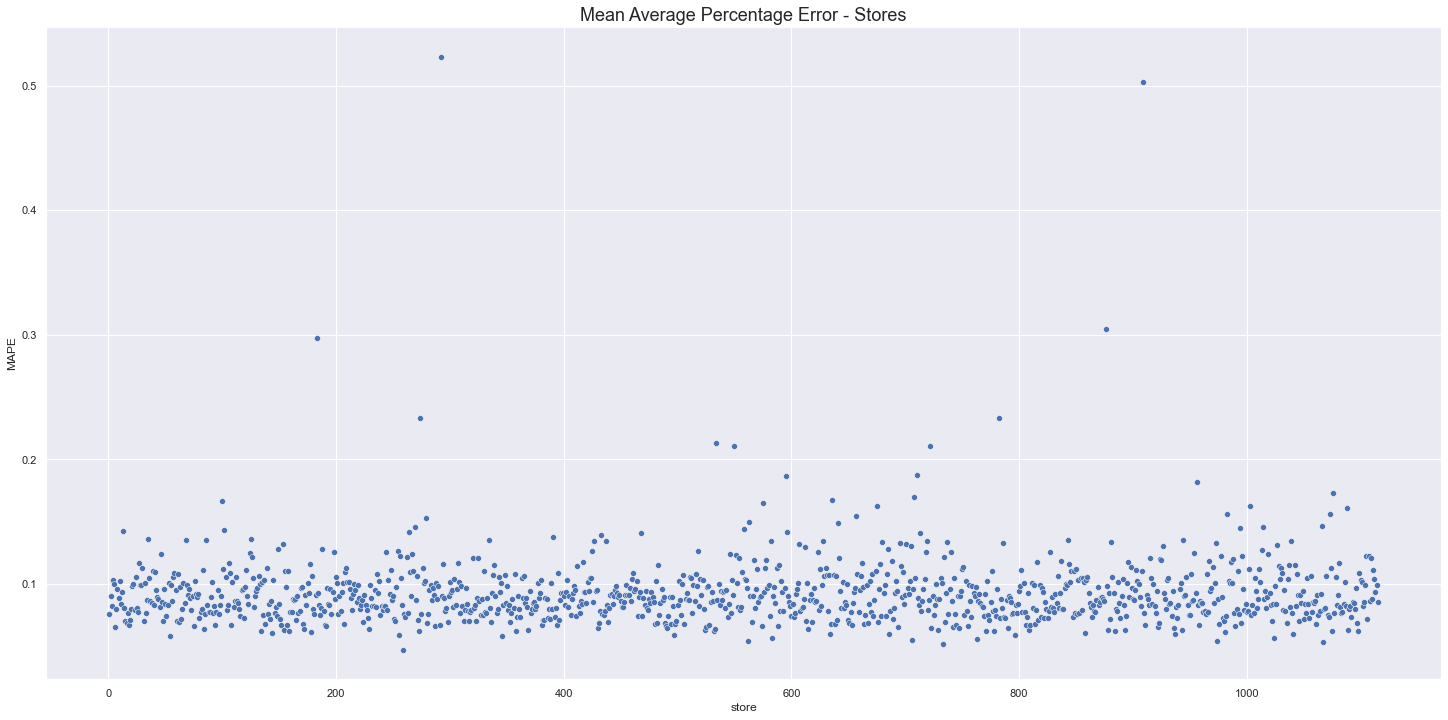

In [156]:
sns.scatterplot(x='store', y='MAPE', data = df92)
plt.title("Mean Average Percentage Error - Stores", fontsize = 18)

### Total Performance

In [149]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenario',0:'Values'})
df93['Values']= df93['Values'].map('${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"$283,302,240.00"
1,worst_scenario,"$282,571,531.85"
2,best_scenario,"$284,032,978.43"


### Machine Learning Performance

C:\Users\fu\AppData\Local\Temp\ipykernel_3116\2987814757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] -df9['predictions']
C:\Users\fu\AppData\Local\Temp\ipykernel_3116\2987814757.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to 

Text(0.5, 1.0, 'Predictions Error')

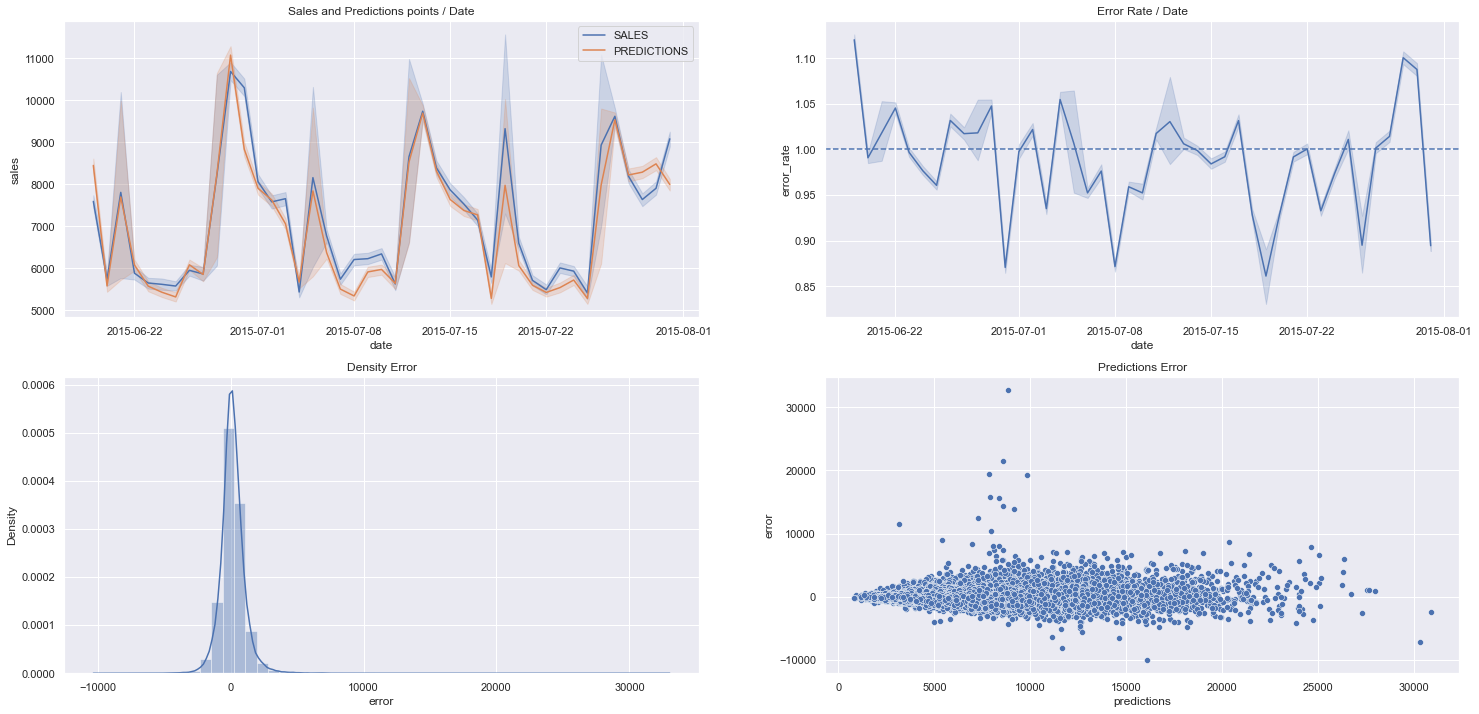

In [157]:
df9['error'] = df9['sales'] -df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']
 
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')
plt.title("Sales and Predictions points / Date")

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')
plt.title("Error Rate / Date")

plt.subplot(2,2,3)
sns.distplot(df9['error'])
plt.title("Density Error")

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error'])
plt.title("Predictions Error")


In [151]:
# Saving thetrained model
pickle.dump( model_xgb_tuned, open( './model_rossmann.pkl', 'wb' ) )


## Deploy Production Model

Check repository.

###  Rossman Class

import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path = ''
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl'))

        
    def data_cleaning(self, df1):
        # Renaming Columns 1.1
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase, cols_old))
        
        # renaming columns:
        df1.columns = cols_new
        
        # Data types 1.3
        df1['date'] = pd.to_datetime(df1['date'])
        
        # 1.5 FillNa
        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
        
        #competition open since month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)
        
        #competition open since year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)
        
        #promo2 since week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)
        
        #promo2 since year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else df1['promo2_since_year'], axis = 1)
        
        #promo_interval
        month_map = {1: 'Jan', 2:'Feb', 3: 'Mar', 4: 'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Ago', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
        
        df1['promo_interval'].fillna(0, inplace = True)
        
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split('.') else 0, axis =1)
        
        # 1.6 Changing data types:
        #competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        
        #promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    
    def feature_engineering(self, df2):
        #year
        df2['year'] = df2['date'].dt.year
        
        #month
        df2['month'] = df2['date'].dt.month
        
        #day
        df2['day'] = df2['date'].dt.day
        
        #week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear
        
        #year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')
        
        #competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)
        
        #promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)
        
        #assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
        
        #state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x =='c' else 'regular_day')
        
        # 3 - Filtering variable
        # 3.1 - lines
        df2 = df2[df2['open'] != 0]
        
        # 3.2 Column selection
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis = 1)
        
        return df2
    
    
    def data_preparation(self, df5):
        #5.2 Rescale
        #competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)
        
        #competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
        
        #promotion time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
        
        #year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)
        
        
        # Encoding - 5.3.1
        # State Holiday  - ONE HOT ENCODING
        df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns =['state_holiday'])
        
        #store type - Label encoding
        df5 = self.store_type_scaler.fit_transform(df5['store_type'])
        
        #assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra':2, 'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)
        
        
        #5.3.3 Nature tranforms
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))
        
        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12 )))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12 )))
        
        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30 )))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30 )))
        
        #week of year:
        df5['week_of_year_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/52 )))
        df5['week_of_year_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/52 )))
        
        
        cols_selected = ['store','promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                         'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_length_months', 'promo_time_week',
                         'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        #, 'day_of_week' 'date', 'sales', 'school_holiday','year','competition_time_month','state_holiday_chritsmas', 'state_holiday_easter_holiday', 'state_holiday_public_holiday', 'state_holiday_regular_day',
        
        return df5[cols_selected]
    
    
    def get_prediction(self, model, original_data, test_data):
        #predicting
        pred = model.predict(test_data)
        
        #joining prediction into original data set
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient ='records', date_format = 'iso')
    
    
        
        
        
        

### API Handler

import pickle
import pandas as pd
from flask import Flask, request, Response
#from rossman.Rossmann import Rossmann

#load model
model = pickle.load(open('./model_rossmann.pkl','rb'))

#start API
app = Flask( __name__ )

@app.route('/rossmann/predict', methods = ['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json:
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index = [0])
        else:
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys())
    
        # start Rossmann class
        pipeline = Rossmann()

        # cleaning data
        df1 = pipeline.data_cleaning(test_raw)

        #feature engineering
        df2 = pipeline.feature_engineering(df1)

        #data preparation
        df3 = pipeline.data_preparation(df2)

        #prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response
    
    else:
        return Response('{}', status=200, mimetype='application/json')
    

if __name__ == '__main__':
    app.run('0.0.0.0')
    



###  API Tester

#Loading test dataset
df10 = pd.read_csv('./test.csv')




#merge testing dataset w store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

#choosing store for prediction
df_test = df_test[df_test['Store'].isin([20,23,22])]

#remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis = 1)


#converting df to json
data = json.dumps( df_test.to_dict(orient = 'records'))




#API call
#url 'http://0.0.0.0:5000/rossmann/predict'
#url = 'https://rossmann-model-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data =data

r = requests.post(url, data=data, headers = header)
print('Status Code {}'.format(r.status_code))




d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys())

d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell ${:,.2f} in the next 6 weeks'.format( d2.loc[i, 'store'], d2.loc[i,'prediction']))
